In [70]:
# install packages
!pip install flask python-chess
!pip install roboflow
!pip install python-chess
!python -m pip install pyyaml
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-wtbj0spi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-wtbj0spi
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done


In [71]:
# General imports
import os, json, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import string
import chess
import chess.engine
import chess.pgn
import chess.engine
from google.colab import drive
import shutil
import pandas as pd
import random
import subprocess
import torch
from ipywidgets import FileUpload, VBox
from IPython.display import display
from PIL import Image
import io

# Roboflow
from roboflow import Roboflow

# Detectron2
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_train_loader
from detectron2.data.transforms import ResizeShortestEdge, RandomFlip, RandomApply
from detectron2.data.datasets.coco import load_coco_json
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T

setup_logger()

<Logger detectron2 (DEBUG)>

First dataset for testing

In [164]:
rf = Roboflow(api_key="lzjSfHvlV9FakBFRlAAL")
project = rf.workspace("aihome-workspace").project("chess-piece-detection_board")
version = project.version(6)
dataset = version.download("coco-mmdetection")

loading Roboflow workspace...
loading Roboflow project...


In [165]:
# connect notebook to google drive so data can be read and written
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
# Define dataset splits
splits = ["train", "valid", "test"]
annotations = {s: os.path.join(dataset.location, s, "_annotations.coco.json") for s in splits}

# Label mapping
label_name_mapping = {
    "bb":"b-bishop", "bh":"b-knight", "bk":"b-king", "bp":"b-pawn",
    "bq":"b-queen", "bt":"b-rook", "wb":"w-bishop", "wh":"w-knight",
    "wk":"w-king", "wp":"w-pawn", "wq":"w-queen", "wt":"w-rook",
    "board":"board", "bn":"b-knight", "br":"b-rook", "wn":"w-knight",
    "wr":"w-rook", "board":"board"
}

# Collect all unique category names across all splits first
# This ensures a consistent mapping for all datasets
all_unique_names = set()
for split in splits:
    ann_file = annotations[split]
    if not os.path.exists(ann_file):
        continue
    with open(ann_file, "r") as f:
        coco_temp = json.load(f)
    for cat in coco_temp.get("categories", []):
        mapped_name = label_name_mapping.get(cat["name"], cat["name"])
        all_unique_names.add(mapped_name)

unique_names_sorted = sorted(list(all_unique_names))
name_to_new_id = {name: i + 1 for i, name in enumerate(unique_names_sorted)}

for split in splits:
    ann_file = annotations[split]

    # Check if annotation file exists
    if not os.path.exists(ann_file):
        print(f"{split}: annotation file not found, skip.")
        continue

    # Backup if not already exists (new backup name to avoid conflicts with previous backup)
    backup_file = ann_file + ".backup_deduplication"
    if not os.path.exists(backup_file):
        shutil.copy(ann_file, backup_file)
        print(f"{split}: backup made -> {backup_file}")

    # Load COCO JSON
    with open(ann_file, "r") as f:
        coco = json.load(f)

    # Apply label name mapping (from original cell mzyFs2NammoK)
    # This part modifies the 'name' attribute of categories in the current coco object
    for cat in coco.get("categories", []):
        if cat["name"] in label_name_mapping:
            cat["name"] = label_name_mapping[cat["name"]]

    # Create a temporary map from old category IDs to their (potentially renamed) names
    old_id_to_name = {cat['id']: cat['name'] for cat in coco['categories']}

    # Update annotations with new category IDs based on the global unique mapping
    annotation_updated_count = 0
    for ann in coco['annotations']:
        old_cat_id = ann['category_id']
        cat_name = old_id_to_name.get(old_cat_id)
        if cat_name and cat_name in name_to_new_id:
            ann['category_id'] = name_to_new_id[cat_name]
            annotation_updated_count += 1

    # Create new categories list based on the global unique mapping
    coco['categories'] = []
    for name in unique_names_sorted:
        coco['categories'].append({"id": name_to_new_id[name], "name": name})

    # Overwrite original file with modified COCO data
    with open(ann_file, "w") as f:
        json.dump(coco, f, indent=2)  # pretty print

    print(f"{split}: {annotation_updated_count} annotations updated with new category IDs and categories deduplicated in {ann_file}")

train: 8070 annotations updated with new category IDs and categories deduplicated in /content/chess-piece-detection_board-6/train/_annotations.coco.json
valid: 1812 annotations updated with new category IDs and categories deduplicated in /content/chess-piece-detection_board-6/valid/_annotations.coco.json
test: 1458 annotations updated with new category IDs and categories deduplicated in /content/chess-piece-detection_board-6/test/_annotations.coco.json


In [167]:
# Difine the path to the location of images and their annotation
train_annotation_file = os.path.join(dataset.location, "train", "_annotations.coco.json")
train_images_path = os.path.join(dataset.location, "train")

val_annotation_file = os.path.join(dataset.location, "valid", "_annotations.coco.json")
val_images_path = os.path.join(dataset.location, "valid")

test_annotation_file = os.path.join(dataset.location, "test", "_annotations.coco.json")
test_images_path = os.path.join(dataset.location, "test")

In [168]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: line 1: nvcc: command not found
torch:  2.9 ; cuda:  cpu
detectron2: 0.6


### Function for data augmentation
To make sure test images have the same specifics as the images of the trainng set, data augmentation techniques are applied.<br>
Images are converted to gray scale and their size is scaled so they are naver larger or smaller than the largest or smallest image in the training set.

In [169]:
class CustomGrayscale(T.Augmentation):
    """
    Apply grayscale conversion to an image and optionally adjust contrast.
    """
    def __init__(self, alpha: float = 1.5, beta: float = 0.0):
        super().__init__()
        self.alpha = alpha  # Contrast control (1.0-3.0)
        self.beta = beta    # Brightness control (0-100)

    def get_transform(self, image):
        # This method returns an actual Transform object.
        # We define an inner class for the specific transform logic.
        class GrayscaleContrastTransform(T.Transform):
            def __init__(self, alpha, beta):
                super().__init__()
                self._alpha = alpha
                self._beta = beta

            def apply_image(self, img: np.ndarray) -> np.ndarray:
                if len(img.shape) == 3 and img.shape[2] == 3:
                    # Convert to grayscale
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    # Apply contrast and brightness adjustment
                    adjusted_img = cv2.convertScaleAbs(gray_img, alpha=self._alpha, beta=self._beta)
                    # Convert back to 3 channels to maintain consistent input shape (but color is gray)
                    return cv2.cvtColor(adjusted_img, cv2.COLOR_GRAY2RGB)
                return img # Return as is if not a 3-channel image

            def apply_coords(self, coords: np.ndarray) -> np.ndarray:
                return coords # Grayscale/contrast doesn't change coordinates

            def apply_segmentation(self, segmentation: np.ndarray) -> np.ndarray:
                return segmentation # Grayscale/contrast doesn't change segmentation masks

        return GrayscaleContrastTransform(self.alpha, self.beta)

'\ndef custom_mapper(dataset_dict):\n    image_filepath = dataset_dict[\'file_name\'] # get image filepath\n    image = cv2.imread(image_filepath) # read in the image\n\n    # Actually apply the predefined augmentations on images (e.g., Resize, RandomFlip, CustomGrayscale)\n    augs = [\n        ResizeShortestEdge(cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, sample_style=\'choice\'),\n        # makes sure the shortest image side agrees with dimensions in the train set\n        CustomGrayscale(alpha=1.5, beta=10) # Apply grayscale class (grayscale & increased contrast)\n    ]\n    # pass the list of augmentations directly to apply_augmentations\n    image, transforms = T.apply_augmentations(augs, image)\n\n    # transform the annotations according to the image transformations (boxes etc)\n    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))\n\n    annos = [\n        detectron2.data.detection_utils.transform_instance_annotations(obj, transforms, 

Determine variables

In [170]:
TRAIN_DATASET_NAME = "ChessImages-train"
VAL_DATASET_NAME = "ChessImages-val"
TEST_DATASET_NAME = "ChessImages-test"
dataset_path = dataset.location
MODEL_CONFIG = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [171]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Helper function to unregister a dataset if it exists
def unregister_if_exists(name):
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
    if name in MetadataCatalog.list():
        MetadataCatalog.remove(name)

# Unregister existing datasets before re-registering
unregister_if_exists(TRAIN_DATASET_NAME)
unregister_if_exists(VAL_DATASET_NAME)
unregister_if_exists(TEST_DATASET_NAME)

register_coco_instances(TRAIN_DATASET_NAME, {}, train_annotation_file, train_images_path)
register_coco_instances(VAL_DATASET_NAME, {}, val_annotation_file, val_images_path)
register_coco_instances(TEST_DATASET_NAME, {}, test_annotation_file, test_images_path)

# The detectron2 dataset dicts and dataset metadata can be read from the DatasetCatalog and
# MetadataCatalog, respectively.
train_metadata = MetadataCatalog.get(TRAIN_DATASET_NAME)
val_metadata = MetadataCatalog.get(VAL_DATASET_NAME)
test_metadata = MetadataCatalog.get(TEST_DATASET_NAME)

train_dicts = DatasetCatalog.get(TRAIN_DATASET_NAME)
val_dicts = DatasetCatalog.get(VAL_DATASET_NAME)
test_dicts = DatasetCatalog.get(TEST_DATASET_NAME)

[01/20 21:06:22 d2.data.datasets.coco]: Loaded 159 images in COCO format from /content/chess-piece-detection_board-6/train/_annotations.coco.json
[01/20 21:06:22 d2.data.datasets.coco]: Loaded 40 images in COCO format from /content/chess-piece-detection_board-6/valid/_annotations.coco.json
[01/20 21:06:22 d2.data.datasets.coco]: Loaded 40 images in COCO format from /content/chess-piece-detection_board-6/test/_annotations.coco.json


In [249]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL_CONFIG))

# IMPORTANT: must match training
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(train_metadata.thing_classes)
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

# Path to the trained model's weights file in Google Drive
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/AI@HomePro/ChessModels/model_mergeDatasets_bias.pth"

# Set the confidence threshold for detections
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Set the Non-Maximum Suppression (NMS) threshold
cfg.MODEL.RPN.NMS_THRESH = 0.2

print(f"Model configuration merged from {MODEL_CONFIG}. Output directory set to {cfg.OUTPUT_DIR}.\nWeights set to {cfg.MODEL.WEIGHTS}. Inference thresholds and device configured.")

Model configuration merged from COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml. Output directory set to ./output.
Weights set to /content/drive/MyDrive/AI@HomePro/ChessModels/model_mergeDatasets_bias.pth. Inference thresholds and device configured.


In [250]:
# Initialize the predictor
cfg.MODEL.DEVICE = "cpu"
predictor = DefaultPredictor(cfg)
print("DefaultPredictor initialized with local weights and updated thresholds.")

[01/20 21:21:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/AI@HomePro/ChessModels/model_mergeDatasets_bias.pth ...
DefaultPredictor initialized with local weights and updated thresholds.


[01/20 21:22:01 d2.data.datasets.coco]: Loaded 40 images in COCO format from /content/chess-piece-detection_board-6/test/_annotations.coco.json


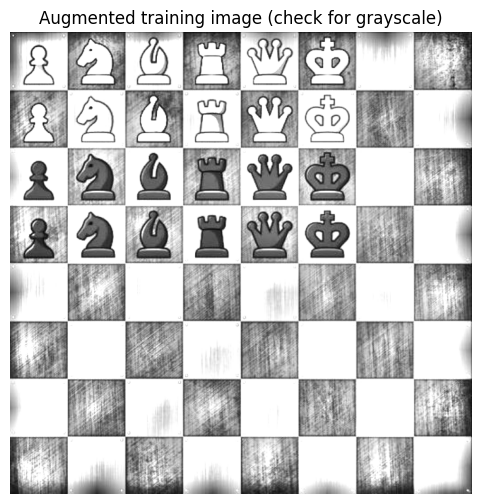

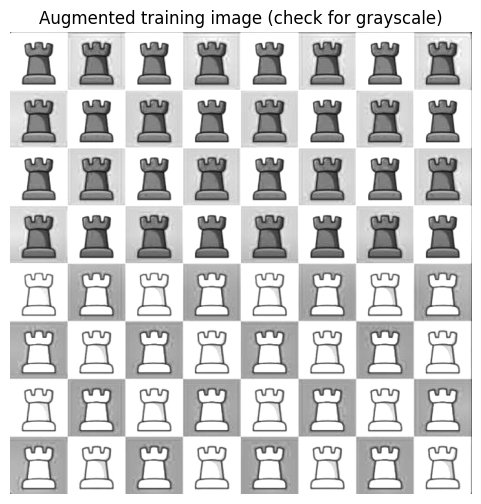

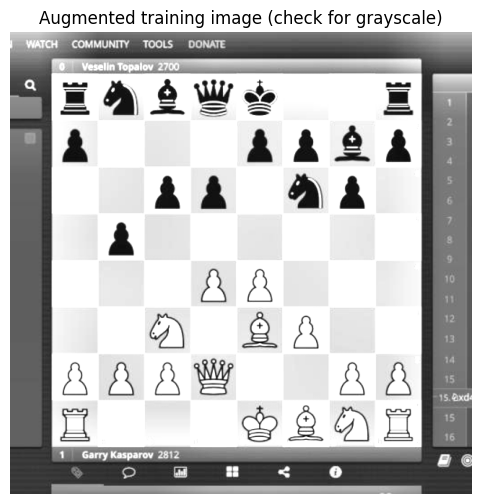

In [251]:
# testing the augmentation techniques on 3 random images
dataset = DatasetCatalog.get(TEST_DATASET_NAME)

for i in range(3):
    sample = dataset[i]
    processed = custom_mapper(sample)

    img = processed["image"].permute(1,2,0).cpu().numpy().astype("uint8")

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title("Augmented training image (check for grayscale)")
    plt.axis("off")
    plt.show()

Het processen doen op een tijdelijk zwart wit beeld met de custommapper functie.<br> Zo blijft de originele afbeelding behouden

In [281]:
uploader = FileUpload(
    accept='image/*',  # alleen afbeeldingen
    multiple=False     # één bestand
)

def on_upload_change(change):
    if uploader.value:
        # Het geüploade bestand pakken
        (filename, fileinfo), = uploader.value.items()
        content = fileinfo['content']
        # Open met PIL
        img = Image.open(io.BytesIO(content)).convert("RGB")
        display(img)
        print(f"Geselecteerd: {filename}, grootte: {len(content)} bytes")

uploader.observe(on_upload_change, names='value')
display(VBox([uploader]))


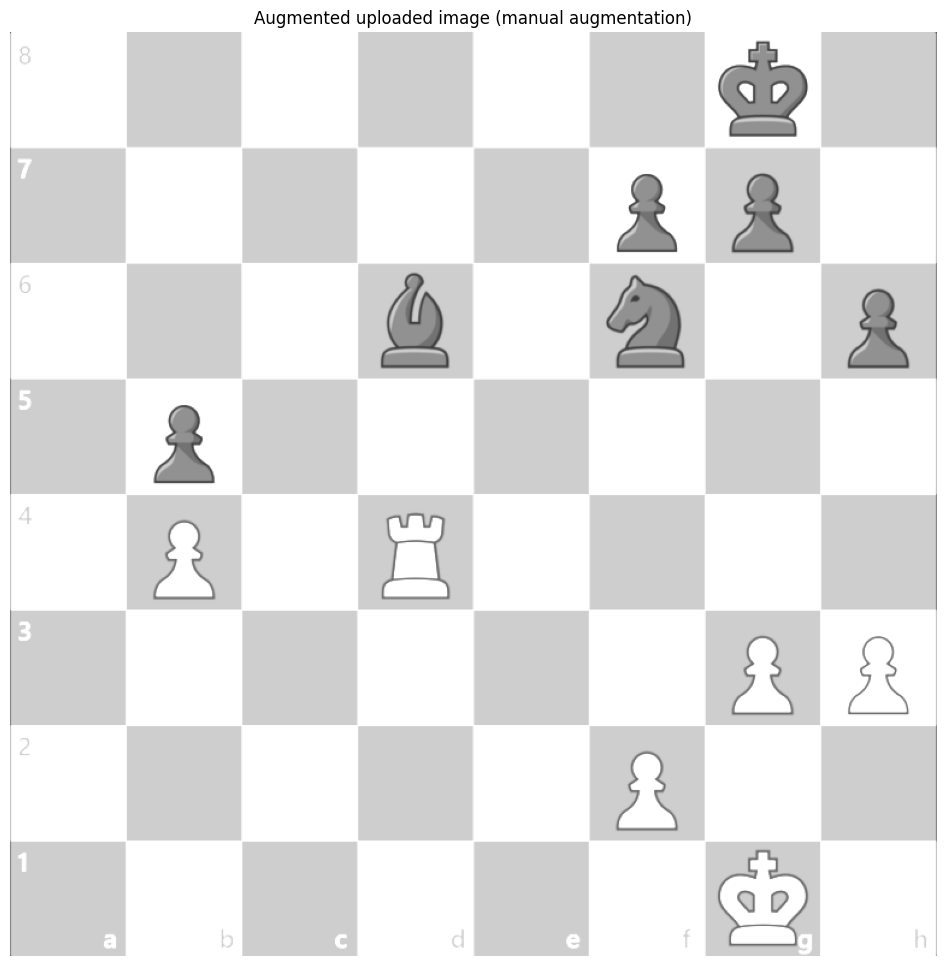

Augmentation performed on uploaded image: image.png - manual mapping (grayscale and resized).


In [253]:
# Get the uploaded image content from the uploader widget
if not uploader.value:
    raise ValueError("Please upload an image using the widget above.")

# Extract the content from the uploaded file
(filename, fileinfo), = uploader.value.items()
content = fileinfo['content']

# Open with PIL and convert to RGB (from bytes directly)
img_pil = Image.open(io.BytesIO(content)).convert("RGB")

# Convert PIL Image (RGB) to NumPy array (RGB)
img_np_rgb = np.array(img_pil)

# Convert from RGB (NumPy) to BGR (OpenCV format, as expected by Predictor and CustomGrayscale internally)
img_np_bgr = cv2.cvtColor(img_np_rgb, cv2.COLOR_RGB2BGR)

# Define the augmentations (same as in custom_mapper)
augs = [
    T.ResizeShortestEdge(cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, sample_style='choice'),
    CustomGrayscale(alpha=1.5, beta=10) # Apply grayscale class (grayscale & increased contrast)
]

# Apply the augmentations to the BGR image. CustomGrayscale returns RGB. `im_processed_rgb` will be RGB.
im_processed_rgb, transforms = T.apply_augmentations(augs, img_np_bgr)

# The DefaultPredictor expects a BGR image. Convert the augmented RGB image to BGR for prediction.
im_for_predictor = cv2.cvtColor(im_processed_rgb.astype(np.uint8), cv2.COLOR_RGB2BGR)

# Now, pass the processed image to the predictor
outputs = predictor(im_for_predictor)

# For displaying with matplotlib, we need RGB. Convert the BGR image back to RGB for plotting.
im_display = cv2.cvtColor(im_for_predictor, cv2.COLOR_BGR2RGB)

# Display the image with predictions
plt.figure(figsize=(12, 12))
plt.imshow(im_display)
plt.axis("off")
plt.title("Augmented uploaded image (manual augmentation)")
plt.show()

# Ensure im_processed is the BGR version used for prediction for subsequent cells
im_processed = im_for_predictor

print(f"Augmentation performed on uploaded image: {filename} - manual mapping (grayscale and resized).")

### Pieces position
Now that the object recognition method was applied on the selected image we want to extract the name of te detected pieces and their location the board from the outputs

In [254]:
pred_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
pred_classes = outputs["instances"].pred_classes.cpu().numpy()
pred_scores = outputs["instances"].scores.cpu().numpy()

class_names = MetadataCatalog.get(VAL_DATASET_NAME).thing_classes

extracted_predictions = []
chessboard_bbox = None

for i in range(len(pred_boxes)):
    bbox_xyxy = pred_boxes[i] # Format (x_min, y_min, x_max, y_max)
    class_id = pred_classes[i]
    score = pred_scores[i]

    # Convert bounding box from (x_min, y_min, x_max, y_max) to (x, y, width, height)
    x_min, y_min, x_max, y_max = bbox_xyxy
    x = float(x_min)
    y = float(y_min)
    width = float(x_max - x_min)
    height = float(y_max - y_min)
    bbox_xywh = [x, y, width, height]

    piece_or_board_name = class_names[class_id]

    if piece_or_board_name == 'board':
        chessboard_bbox = {
            "bbox": bbox_xywh,
            "score": float(score)
        }
    else:
        extracted_predictions.append({
            "piece_name": piece_or_board_name,
            "bbox": bbox_xywh,
            "score": float(score)
        })

print("Extracted Predictions (with float conversion):")
for prediction in extracted_predictions:
    print(prediction)

if chessboard_bbox:
    print(f"\nDetected Chessboard: {chessboard_bbox}")
else:
    print("\nNo Chessboard object detected directly.")

Extracted Predictions (with float conversion):
{'piece_name': 'w-king', 'bbox': [585.8087768554688, 677.5946044921875, 80.26287841796875, 82.90313720703125], 'score': 0.9924255609512329}
{'piece_name': 'w-pawn', 'bbox': [500.7620544433594, 595.28466796875, 55.207733154296875, 70.9068603515625], 'score': 0.9846345782279968}
{'piece_name': 'w-pawn', 'bbox': [597.9384765625, 500.2046813964844, 54.45513916015625, 69.25186157226562], 'score': 0.9792364835739136}
{'piece_name': 'w-pawn', 'bbox': [691.7323608398438, 499.9410095214844, 56.84442138671875, 69.34994506835938], 'score': 0.9760420322418213}
{'piece_name': 'w-rook', 'bbox': [306.8411865234375, 398.6396484375, 59.92864990234375, 73.97564697265625], 'score': 0.9738389849662781}
{'piece_name': 'w-pawn', 'bbox': [119.11614990234375, 405.23541259765625, 50.71427917480469, 66.669921875], 'score': 0.971606969833374}
{'piece_name': 'b-king', 'bbox': [587.5178833007812, 8.652539253234863, 77.86077880859375, 77.51649475097656], 'score': 0.912

### visualizing piece positions in an image
The augmented image is plotted.<br>
For the detected pieces the bounding box is drawn together with the detection score, X and y minimal and maximal coordinates and box width and height.


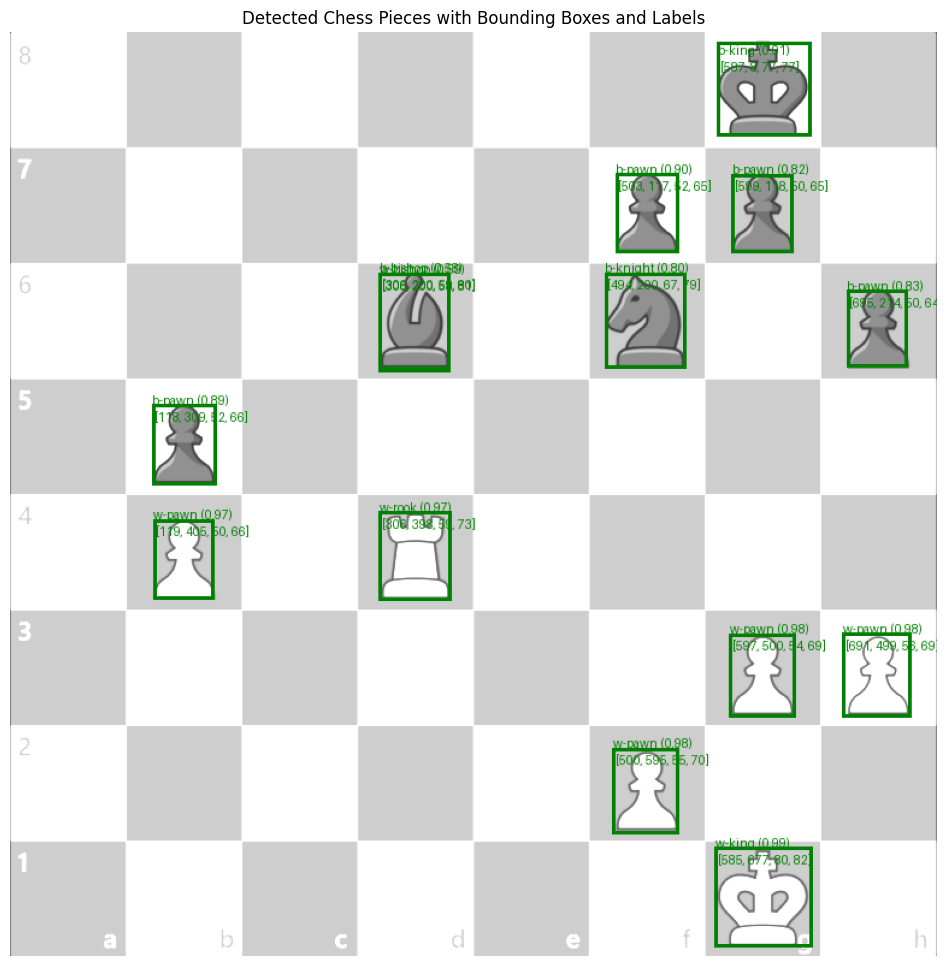

In [255]:
# Convert OpenCV image (BGR) to PIL Image (RGB)
# Use 'im_processed' instead of 'im' as this is the image that was passed to the predictor
image_pil = Image.fromarray(cv2.cvtColor(im_processed, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(image_pil)

# Iterate through extracted_predictions and draw on the image
for prediction in extracted_predictions:
    piece_name = prediction['piece_name']
    bbox_xywh = prediction['bbox'] # [x, y, width, height]
    score = prediction['score']

    # Convert bbox from (x, y, width, height) to (x_min, y_min, x_max, y_max) for drawing
    x, y, width, height = bbox_xywh
    x_min, y_min = x, y
    x_max, y_max = x + width, y + height

    # Draw the rectangle
    draw.rectangle([x_min, y_min, x_max, y_max], outline="green", width=3)

    # Format text label
    label_text = f"{piece_name} ({score:.2f})\n [{int(x)}, {int(y)}, {int(width)}, {int(height)}]"

    # Draw text label slightly above the bounding box
    text_position = (x_min, y_min - 10 if y_min - 10 > 0 else y_min )
    draw.text(text_position, label_text, fill="green")

# Display the image with predictions
plt.figure(figsize=(12, 12))
plt.imshow(image_pil)
plt.axis("off")
plt.title("Detected Chess Pieces with Bounding Boxes and Labels")
plt.show()


## Identifying piece position on the board
We want to have more info about the piece positions than just there coordinates in the immage.<br>
We want there actual coordinates on the chess board.<br><br>

For this we have to divide the board in an 8x8 grid and look in which of the squares each piece is located.<br><br>

Based on the bounding box of the detected board an 8x8 grid is defined in the image. When this is done it is investigated in which of the squares each piece is located.<br><br>

This method depends on the assumption that a board will be detected. There is a fallback integrated for when there's no board detected. In that cass the full image size will be divided in an 8x8 grid.

In [256]:
image_height, image_width, _ = im_processed.shape

# Prioritize using the directly detected chessboard bounding box if available
if 'chessboard_bbox' in locals() and chessboard_bbox:
    board_x, board_y, board_w, board_h = chessboard_bbox['bbox']
    min_x_grid = board_x
    min_y_grid = board_y
    max_x_grid = board_x + board_w
    max_y_grid = board_y + board_h

    board_side_length_x = max_x_grid - min_x_grid
    board_side_length_y = max_y_grid - min_y_grid

    if board_side_length_x > 0 and board_side_length_y > 0:
        square_size_x_grid = board_side_length_x / 8.0
        square_size_y_grid = board_side_length_y / 8.0
    else:
        # Fallback if detected board dimensions are problematic
        min_x_grid = 0.0
        min_y_grid = 0.0
        max_x_grid = float(image_width)
        max_y_grid = float(image_height)
        board_side_length_x = max_x_grid - min_x_grid
        board_side_length_y = max_y_grid - min_y_grid
        square_size_x_grid = image_width / 8.0
        square_size_y_grid = image_height / 8.0
        print("Warning: Detected board dimensions were problematic, falling back to full image dimensions.")

    print("Calculated Chessboard Boundaries and Square Sizes (from direct board detection):")

else:
    # Fallback: if no pieces are detected, assume the board is the full image
    min_x_grid = 0.0
    min_y_grid = 0.0
    max_x_grid = float(image_width)
    max_y_grid = float(image_height)
    board_side_length_x = max_x_grid - min_x_grid
    board_side_length_y = max_y_grid - min_y_grid
    square_size_x_grid = image_width / 8.0
    square_size_y_grid = image_height / 8.0
    print("Warning: No pieces or board detected, assuming board covers full image.")

chessboard_boundaries_from_image = {
    "min_x": min_x_grid,
    "min_y": min_y_grid,
    "max_x": max_x_grid,
    "max_y": max_y_grid,
    "board_side_length_x": board_side_length_x,
    "board_side_length_y": board_side_length_y,
    "square_size_x": square_size_x_grid,
    "square_size_y": square_size_y_grid
}

for key, value in chessboard_boundaries_from_image.items():
    print(f"  {key}: {value}")

  min_x: 0.0
  min_y: 0.0
  max_x: 770.0
  max_y: 768.0
  board_side_length_x: 770.0
  board_side_length_y: 768.0
  square_size_x: 96.25
  square_size_y: 96.0


### Determine board oriëntation
In our dataset board immages have different orientations. Somtimes white is at the top, sometimes black is.<br>
However, for an online chess game coordinates have to be given from combinations 1-8 and a-h.<br>
We have to give the correct coördinates to the correct board squares to do this.<br>
Black always starts at the 'h' side of the board and whit at the 'a' side. So to put correct coordinate names on the board squares we look af at the average coordinates of the pieces of both colors and from this we determine on which side the colors are mainly placed and where letters for coordinates have to be placed.<br>
If necessary board can be turned 180 degrees to match correct coordinate names.<br>
This is not a very robust technique because some game evutions might cause a shift in the average positions.<br>
When you use a dataset in which all boards are already in correct position, this step can be skipped.

In [257]:
white_y_coords = []
black_y_coords = []

for prediction in extracted_predictions:
    piece_name = prediction['piece_name']
    bbox = prediction['bbox'] # [x, y, width, height]
    y_center = bbox[1] + bbox[3] / 2

    if piece_name.startswith('w-'): # Changed from 'w-' to 'w'
        white_y_coords.append(y_center)
    elif piece_name.startswith('b-'): # Changed from 'b-' to 'b'
        black_y_coords.append(y_center)

# Calculate average y-coordinates
avg_white_y = sum(white_y_coords) / len(white_y_coords) if white_y_coords else None
avg_black_y = sum(black_y_coords) / len(black_y_coords) if black_y_coords else None

# Determine board orientation dynamically
white_at_top = None
if avg_white_y is not None and avg_black_y is not None:
    if avg_white_y < avg_black_y:
        white_at_top = True
    else:
        white_at_top = False

print(f"Average Y-coordinate for White pieces: {avg_white_y:.2f}" if avg_white_y is not None else "Average Y-coordinate for White pieces: Not detected")
print(f"Average Y-coordinate for Black pieces: {avg_black_y:.2f}" if avg_black_y is not None else "Average Y-coordinate for Black pieces: Not detected")
print(f"Is White's side at the top of the image? {white_at_top}")

Average Y-coordinate for White pieces: 505.00
Average Y-coordinate for Black pieces: 202.64
Is White's side at the top of the image? False


In the following part chess pieces are mapped to there corrresponding board coordiantes.

In [258]:
new_chessboard = [['' for _ in range(8)] for _ in range(8)]

# Extract chessboard parameters from the detected boundaries
if not chessboard_boundaries_from_image:
    # a fall back for if the previous cell detecting chessboard boundaries didn't work
    image_height, image_width, _ = im_processed.shape
    min_x_new = 0.0
    min_y_new = 0.0
    square_size_x_new = float(image_width) / 8.0
    square_size_y_new = float(image_height) / 8.0
else:
    min_x_new = chessboard_boundaries_from_image["min_x"]
    min_y_new = chessboard_boundaries_from_image["min_y"]
    square_size_x_new = chessboard_boundaries_from_image["square_size_x"]
    square_size_y_new = chessboard_boundaries_from_image["square_size_y"]

# Function to map puece coordinates to board coordinates for the new grid
def get_board_coordinates_new_grid_dynamic_orientation(x_center, y_center, min_x_b, min_y_b, sq_size_x, sq_size_y, white_at_top_flag):
    col_index_raw = int((x_center - min_x_b) / sq_size_x)
    row_index_raw = int((y_center - min_y_b) / sq_size_y)

    # Ensure indices are within bounds (0-7)
    col_index_raw = max(0, min(7, col_index_raw))
    row_index_raw = max(0, min(7, row_index_raw))

    # Adjust row and column indices based on white_at_top flag to represent ranks 1-8 from bottom to top and files a-h from left to right
    if white_at_top_flag:
        # If white is at the top of the image (board flipped 180 degrees),
        # both rows and columns need to be reversed from the raw image indices.
        row_index_for_display = 7 - row_index_raw # Reverse rows (rank 1 at bottom, rank 8 at top)
        col_index_for_display = 7 - col_index_raw # Reverse columns (file 'a' becomes 'h', etc.)
    else:
        # If white is at the bottom of the image (standard orientation),
        # raw indices map directly to display indices.
        row_index_for_display = row_index_raw
        col_index_for_display = col_index_raw

    return row_index_for_display, col_index_for_display

# Map detected pieces to the new chessboard grid with dynamic orientation
for prediction in extracted_predictions:
    piece_name = prediction['piece_name']
    bbox = prediction['bbox']

    xmin, ymin, xmax, ymax = bbox
    x_center = xmin + xmax / 2
    y_center = ymin + ymax / 2

    row_idx, col_idx = get_board_coordinates_new_grid_dynamic_orientation(x_center, y_center, min_x_new, min_y_new, square_size_x_new, square_size_y_new, white_at_top)

    # Place the piece in the new chessboard grid
    # For simplicity, if multiple pieces fall into the same square, the last one detected wins.
    new_chessboard[row_idx][col_idx] = piece_name

# Print the textual representation of the new chessboard
print("\nChessboard State (Textual Representation - Image Dimensions Grid with Dynamic Orientation):\n")
# Print files (a-h)
print("  " + " ".join(string.ascii_lowercase[:8]))

# Define mapping for piece types to standard chess notation
piece_notation_map = {
    'pawn': 'P',
    'rook': 'R',
    'knight': 'N',
    'bishop': 'B',
    'queen': 'Q',
    'king': 'K'
}

# Print pieces location
for r_idx, row in enumerate(new_chessboard):
    rank_num = 8 - r_idx
    row_display = []
    for piece in row:
        if piece: # piece will be something like 'b-p', 'w-q', 'b-k'
            color_prefix = piece[0] # 'w' or 'b'
            piece_type = piece.split('-')[1] # e.g., 'pawn', 'queen', 'king'
            fen_char = piece_notation_map.get(piece_type, piece_type[0].upper()) # Get 'P', 'R', etc.

            if color_prefix == 'w':
                row_display.append(fen_char.upper())
            else:
                row_display.append(fen_char.lower())
        else:
            row_display.append(".") # Using '.' for empty squares for better visual clarity
    print(f"{rank_num} {" ".join(row_display)}")


Chessboard State (Textual Representation - Image Dimensions Grid with Dynamic Orientation):

  a b c d e f g h
8 . . . . . . k .
7 . . . . . p p .
6 . . . b . n . p
5 . p . . . . . .
4 . P . R . . . .
3 . . . . . . P P
2 . . . . . P . .
1 . . . . . . K .


# Saving the Chessboard State
The chessboard state is saved in a FEN string which is used later as input for the recommmender system and the genetic algorithm. Because it is impossible to detect certain characteristics of the game from an image a standard setting is given: Assuming white to move, no castling, no en passant, 0 halfmoves, 1 fullmove

In [259]:
# Define mapping for piece types to standard FEN notation (uppercase for white, lowercase for black)
fen_piece_notation_map = {
    'pawn': 'P',
    'rook': 'R',
    'knight': 'N',
    'bishop': 'B',
    'queen': 'Q',
    'king': 'K'
}

def board_to_fen(board_state, piece_map):
    fen_ranks = []
    for row_idx in range(8):
        row_fen = []
        empty_count = 0
        for col_idx in range(8):
            piece = board_state[row_idx][col_idx]
            if piece:
                if empty_count > 0:
                    row_fen.append(str(empty_count))
                    empty_count = 0
                color_prefix = piece[0] # 'w' or 'b'
                piece_type = piece.split('-')[1]
                fen_char = piece_map.get(piece_type, piece_type[0].upper()) # White = uppercase
                if color_prefix == 'b':
                    fen_char = fen_char.lower() # Black = lowercase
                row_fen.append(fen_char)
            else:
                empty_count += 1
        if empty_count > 0:
            row_fen.append(str(empty_count))
        fen_ranks.append("".join(row_fen))

    color2play = input(
        "is white to move?: y/n"
    )
    if color2play == 'y':
        color2play = 'w'
    else:
        color2play = 'b'

    # Join ranks with '/' and add other FEN components
    # Assuming white to move, no castling, no en passant, 0 halfmoves, 1 fullmove for simplicity
    fen_string = "/".join(fen_ranks) + " " + color2play + " - - 0 1"

    return fen_string

# Convert the new_chessboard state to a FEN string
fen_string = board_to_fen(new_chessboard, fen_piece_notation_map)
print(f"FEN string: {fen_string}")

is white to move?: y/ny
FEN string: 6k1/5pp1/3b1n1p/1p6/1P1R4/6PP/5P2/6K1 w - - 0 1


As last step in detection of board state the determined grid is plotted on the augmented image to check if the determined grid in fact overlaps with the squares on the chessboard

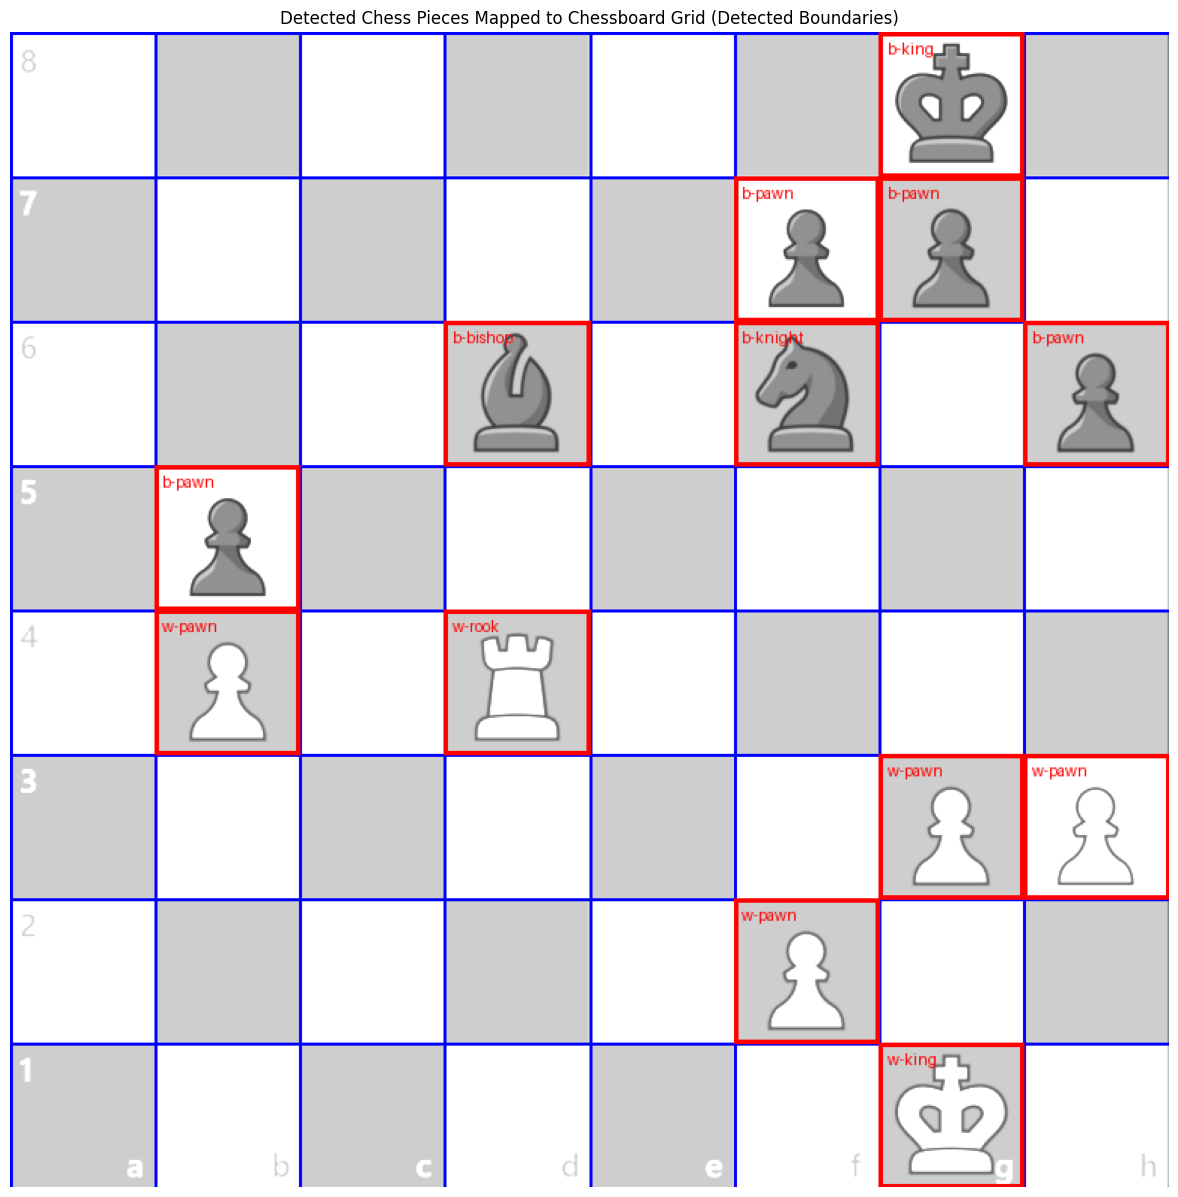

In [260]:
image_for_display = im_processed.copy()

# Rotate the image 180 degrees if White's side is at the top to align with logical board
if 'white_at_top' in locals() and white_at_top:
    image_for_display = cv2.rotate(image_for_display, cv2.ROTATE_180)

image_pil_new_grid = Image.fromarray(cv2.cvtColor(image_for_display, cv2.COLOR_BGR2RGB))
draw_new_grid = ImageDraw.Draw(image_pil_new_grid)

# Extract chessboard parameters for the new grid from detected boundaries
if not chessboard_boundaries_from_image:
    # This case should ideally be handled by the fallback in the detection cell
    # but adding a check here for robustness.
    image_height, image_width, _ = im_processed.shape
    min_x_new = 0.0
    min_y_new = 0.0
    max_x_new = float(image_width)
    max_y_new = float(image_height)
    square_size_x_new = float(image_width) / 8.0
    square_size_y_new = float(image_height) / 8.0
else:
    min_x_new = chessboard_boundaries_from_image["min_x"]
    min_y_new = chessboard_boundaries_from_image["min_y"]
    max_x_new = chessboard_boundaries_from_image["max_x"]
    max_y_new = chessboard_boundaries_from_image["max_y"]
    square_size_x_new = chessboard_boundaries_from_image["square_size_x"]
    square_size_y_new = chessboard_boundaries_from_image["square_size_y"]

# Draw the 8x8 chessboard grid lines on the image using detected boundaries
# Draw 9 vertical lines
for i in range(9):
    x_coord = min_x_new + i * square_size_x_new
    # Ensure lines are drawn within the detected board boundaries
    draw_new_grid.line([(x_coord, min_y_new), (x_coord, max_y_new)], fill="blue", width=2)

# Draw 9 horizontal lines
for i in range(9):
    y_coord = min_y_new + i * square_size_y_new
    # Ensure lines are drawn within the detected board boundaries
    draw_new_grid.line([(min_x_new, y_coord), (max_x_new, y_coord)], fill="blue", width=2)

# Iterate through the new_chessboard grid and draw bounding boxes around squares with pieces
for r_idx, row in enumerate(new_chessboard):
    for col_idx, piece in enumerate(row):
        if piece:
            # Calculate pixel coordinates for the current square based on detected boundaries
            square_x_min = min_x_new + col_idx * square_size_x_new
            square_y_min = min_y_new + r_idx * square_size_y_new
            square_x_max = square_x_min + square_size_x_new
            square_y_max = square_y_min + square_size_y_new

            # Draw the rectangle around the square
            draw_new_grid.rectangle([square_x_min, square_y_min, square_x_max, square_y_max], outline="red", width=3)

            # Format text label to show the full piece name
            label_text = piece # Use the full piece name string directly (e.g., 'b-pawn', 'w-king')

            # Draw text label slightly offset from top-left
            text_position = (square_x_min + 5, square_y_min + 5)
            draw_new_grid.text(text_position, label_text, fill="red")

# Display the image with the overlaid grid lines and piece detections
plt.figure(figsize=(15, 15))
plt.imshow(image_pil_new_grid)
plt.axis("off")
plt.title("Detected Chess Pieces Mapped to Chessboard Grid (Detected Boundaries)")
plt.show()

# Recommender system
From the lichess api we build our own move database, with moves deemed 'worthy'.<br>
For a given board state we look in te database for possible moves, the highest scoring moves are extracted.<br>
This is a proof of concept and our database is still limited, this means that it will not find a response for all possible states.<br>
If no good move is found, the board is just shown in the old setup.

In [261]:
df_db = pd.read_csv("/content/drive/MyDrive/AI@HomePro/ChessModels/chess_games_filtered.csv")

In [262]:
df_db.columns

Index(['game_id', 'fen', 'move', 'result'], dtype='object')

In [263]:
def build_move_statistics_with_entropy(df_db: pd.DataFrame, alpha: float = 0.3):
    """
    Builds move statistics using popularity, win rate, and move entropy.
    """

    df_db = df_db.copy()

    # Split the FEN string into its components first
    fen_parts = df_db['fen'].str.split(' ', expand=True)
    expected_parts = 6
    if fen_parts.shape[1] != expected_parts:
        raise ValueError(
            f"Invalid FEN format: expected {expected_parts} fields, "
            f"got {fen_parts.shape[1]}"
        )

    if fen_parts.isnull().any().any():
        invalid_rows = fen_parts[fen_parts.isnull().any(axis=1)]
        raise ValueError(
            f"Invalid FEN strings detected in {len(invalid_rows)} rows."
        )

    # Assign validated FEN components
    df_db['board_state'] = fen_parts[0]
    df_db['active_color'] = fen_parts[1]
    df_db['castling_rights'] = fen_parts[2]
    df_db['en_passant_square'] = fen_parts[3]
    df_db['halfmove_clock'] = fen_parts[4]
    df_db['fullmove_number'] = fen_parts[5]

    # Remove the original FEN column
    df_db.drop(columns=['fen'], inplace=True)

    # Convert result to numeric score (from side-to-move perspective)
    def result_to_score(row):
        if row['result'] == '1-0':
            return 1.0 if row['active_color'] == 'w' else 0.0
        elif row['result'] == '0-1':
            return 1.0 if row['active_color'] == 'b' else 0.0
        else:
            return 0.5

    df_db['score'] = df_db.apply(result_to_score, axis=1)

    # Aggregate move statistics
    move_stats = (
        df_db
        .groupby([
            'board_state',
            'active_color',
            'castling_rights',
            'en_passant_square',
            'move'
        ])
        .agg(
            count=('move', 'size'),
            win_rate=('score', 'mean')
        )
        .reset_index()
    )

    #print(move_stats)

    # Calculate total moves per position
    move_stats['total_moves'] = (
        move_stats
        .groupby([
            'board_state',
            'active_color',
            'castling_rights',
            'en_passant_square'
        ])['count']
        .transform('sum')
    )

    #print(move_stats.sort_values(by="count", ascending = False))

    # Probability of each move
    move_stats['probability'] = move_stats['count'] / move_stats['total_moves']

    # Surprise factor (using natural logarithm)
    move_stats['surprise'] = -np.log(move_stats['probability'])

    # Base score (popularity × success)
    move_stats['base_score'] = (
        move_stats['win_rate'] * np.log1p(move_stats['count']) # log1p handles count = 0 gracefully
    )

    # Entropy-weighted final score
    move_stats['final_score'] = (
        move_stats['base_score'] * (1 + alpha * move_stats['surprise'])
    )

    return move_stats.sort_values('final_score', ascending=False)


In [264]:
move_stats = build_move_statistics_with_entropy(df_db, alpha=0.2)

In [265]:
def recommend_moves_with_entropy(
    fen_string: str,
    move_stats: pd.DataFrame,
    n: int = 3
):
    """
    Recommend moves using popularity, success rate, and surprise factor.
    """

    fen_parts = fen_string.split(' ')
    if len(fen_parts) != 6:
        raise ValueError("Invalid FEN string")

    board_state, active_color, castling_rights, en_passant_square, _, _ = fen_parts

    candidates = move_stats[
        (move_stats['board_state'] == board_state) &
        (move_stats['active_color'] == active_color) &
        (move_stats['castling_rights'] == castling_rights) &
        (move_stats['en_passant_square'] == en_passant_square)
    ]

    # Cold-start fallback
    if candidates.empty:
        candidates = move_stats[
            move_stats['board_state'] == board_state
        ]

    return candidates.head(n)[
        [
            'move',
            'count',
            'win_rate',
            'surprise',
            'final_score'
        ]
    ]


In [266]:
# example use: detect five best possible moves
start_fen = fen_string
recommended_moves_start = recommend_moves_with_entropy(start_fen, move_stats, n=5)
print(f"Aanbevolen zetten voor de startpositie ({start_fen}):")
display(recommended_moves_start)

Aanbevolen zetten voor de startpositie (6k1/5pp1/3b1n1p/1p6/1P1R4/6PP/5P2/6K1 w - - 0 1):


Empty DataFrame
Columns: [move, count, win_rate, surprise, final_score]
Index: []

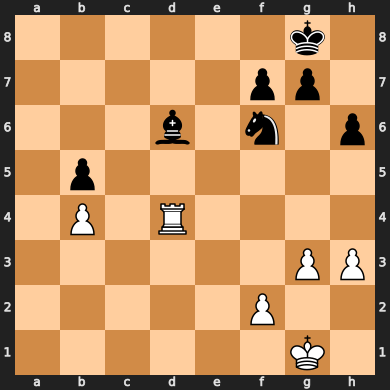

In [267]:
board = chess.Board(start_fen)
display(board)

In [268]:
if not recommended_moves_start.empty:
    # Get the first recommended move (UCI format) from the DataFrame
    first_recommended_move_uci = recommended_moves_start.iloc[0]['move']

    # Make the move on the board
    try:
        board.push_uci(first_recommended_move_uci)
        print(f"Board after first recommended move ({first_recommended_move_uci}):")
        display(board)
    except ValueError as e:
        print(f"Could not apply move {first_recommended_move_uci} to the board: {e}")
else:
    print("No recommended moves found for the current FEN in the training data.")

No recommended moves found for the current FEN in the training data.


# Genetic algorithm
Our genetic algorithm is largely based on the code of the following repository:<br>
https://github.com/mrinoybanerjee/Genetic-Chess-Algorithm

### Board Evaluation Function

We started with a function that evaluates the input FEN string.<br>
This function creates a board score where it attributes a weight to the pieces based on their importance. It combines this with a weight for the position of a piece. This position score is based on tactical relavance.


In [269]:
# waarden zijn door ai licht aangepast tov van vb
# kijken of we die kunnen bepalen obv lichess?

# 1. Define PIECE_VALUES
PIECE_VALUES = {
    chess.PAWN: 100,
    chess.KNIGHT: 320,
    chess.BISHOP: 330,
    chess.ROOK: 500,
    chess.QUEEN: 900,
    chess.KING: 20000
}

# 2. Define MAPS (Positional Score Tables)
# White's positional maps. Black's maps will be mirrored.
# how valuable a particular chess piece is at each square on the board (based on

# Pawn positional map
pawn_map_white = np.array([
    [0,  0,  0,  0,  0,  0,  0,  0],
    [100,100,100,100,100,100,100,100],
    [ 70, 70, 80, 90, 90, 80, 70, 70],
    [ 50, 50, 60, 75, 75, 60, 50, 50],
    [ 30, 30, 35, 50, 50, 35, 30, 30],
    [ 10, 15, 20, 30, 30, 20, 15, 10],
    [ 0, 0, -5, -10, -10,  -5,  0, 0],
    [ 0,  0,  0,  0,  0,  0,  0,  0]
])

# Knight positional map
knight_map_white = np.array([
    [-50,-40,-30,-30,-30,-30,-40,-50],
    [-40,-20,  0,  0,  0,  0,-20,-40],
    [-30,  0, 10, 15, 15, 10,  0,-30],
    [-30,  5, 15, 20, 20, 15,  5,-30],
    [-30,  0, 15, 20, 20, 15,  0,-30],
    [-30,  5, 10, 15, 15, 10,  5,-30],
    [-40,-20,  0,  5,  5,  0,-20,-40],
    [-50,-40,-30,-30,-30,-30,-40,-50]
])

# Bishop positional map
bishop_map_white = np.array([
    [-20,-10,-10,-10,-10,-10,-10,-20],
    [-10,  0,  0,  0,  0,  0,  0,-10],
    [-10,  0,  5, 10, 10,  5,  0,-10],
    [-10,  5,  5, 10, 10,  5,  5,-10],
    [-10,  0, 10, 10, 10, 10,  0,-10],
    [-10, 10, 10, 10, 10, 10, 10,-10],
    [-10,  5,  0,  0,  0,  0,  5,-10],
    [-20,-10,-10,-10,-10,-10,-10,-20]
])

# Rook positional map
rook_map_white = np.array([
    [0,   5,  10,  10,  10,  10,   5,  0],
    [20, 30, 30, 30, 30, 30, 30, 20],
    [0,   5,  10,  10,  10,  10,   5,  0],
    [0,   0,   5,   5,   5,   5,   0,  0],
    [0,   0,   0,   0,   0,   0,   0,  0],
    [-5,  -5,  0,   0,   0,   0,  -5, -5],
    [-15,-10, -5,   0,   0,  -5, -10, -15],
    [-30,-20,-10,  -5,  -5,-10,-20,-30]
])

# Queen positional map
queen_map_white = np.array([
    [-20,-10,-10, -5, -5,-10,-10,-20],
    [-10,  0,  0,  0,  0,  0,  0,-10],
    [-10,  0,  5,  5,  5,  5,  0,-10],
    [-5,   0,  5,  5,  5,  5,  0, -5],
    [ 0,   0,  5,  5,  5,  5,  0, -5],
    [-10,  5,  5,  5,  5,  5,  0,-10],
    [-10,  0,  5,  0,  0,  0,  0,-10],
    [-20,-10,-10, -5, -5,-10,-10,-20]
])

# King positional map
king_map_white = np.array([
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-30,-40,-40,-50,-50,-40,-40,-30],
    [-20,-30,-30,-40,-40,-30,-30,-20],
    [-10,-20,-20,-20,-20,-20,-20,-10],
    [ 5, 5,  0,  0,  0,  0, 5, 5],
    [ 5, 15, 0,  0,  0, 0, 15, 5]
])


MAPS = {
    (chess.PAWN, chess.WHITE): pawn_map_white,
    (chess.PAWN, chess.BLACK): np.flip(pawn_map_white, axis=0),
    (chess.KNIGHT, chess.WHITE): knight_map_white,
    (chess.KNIGHT, chess.BLACK): np.flip(knight_map_white, axis=0),
    (chess.BISHOP, chess.WHITE): bishop_map_white,
    (chess.BISHOP, chess.BLACK): np.flip(bishop_map_white, axis=0),
    (chess.ROOK, chess.WHITE): rook_map_white,
    (chess.ROOK, chess.BLACK): np.flip(rook_map_white, axis=0),
    (chess.QUEEN, chess.WHITE): queen_map_white,
    (chess.QUEEN, chess.BLACK): np.flip(queen_map_white, axis=0),
    (chess.KING, chess.WHITE): king_map_white,
    (chess.KING, chess.BLACK): np.flip(king_map_white, axis=0)
}


# 3. Create the evaluate_board function, to evaluate board with modified weights
def evaluate_board(fen_string, weights):
    board = chess.Board(fen_string)
    score = 0

    # weights: (pawn_weight, knight_weight, bishop_weight, rook_weight, queen_weight, positional_factor)
    pawn_weight, knight_weight, bishop_weight, rook_weight, queen_weight, positional_factor = weights

    for square in chess.SQUARES:
        piece = board.piece_at(square) # Corrected: pieceat to piece_at

        if piece is not None:
            # Get piece type and color
            piece_type = piece.piece_type
            piece_color = piece.color

            # Material value
            material_value = PIECE_VALUES.get(piece_type, 0)

            # Apply specific weight based on piece type
            if piece_type == chess.PAWN:
                material_value *= pawn_weight
            elif piece_type == chess.KNIGHT:
                material_value *= knight_weight
            elif piece_type == chess.BISHOP:
                material_value *= bishop_weight
            elif piece_type == chess.ROOK:
                material_value *= rook_weight
            elif piece_type == chess.QUEEN:
                material_value *= queen_weight
            # King's material value is fixed as it's not captured in standard play scoring

            # Positional score
            # Determine rank and file from square
            rank = chess.square_rank(square) #1-8
            file = chess.square_file(square) #a-h

            # Get the correct positional map for the piece
            positional_map = MAPS.get((piece_type, piece_color), None)
            positional_score = 0
            if positional_map is not None:
                positional_score = positional_map[rank][file] * positional_factor

            # Combine and add/subtract from score
            combined_value = material_value + positional_score
            if piece_color == chess.WHITE:
                score += combined_value
            else:
                score -= combined_value

    return score

print("PIECE_VALUES, MAPS, and evaluate_board function defined.")

PIECE_VALUES, MAPS, and evaluate_board function defined.


## Implement Core Genetic Algorithm Components

1.  generate_population
2.  select_parents
3.  crossover
4.  mutate

In [270]:
# 1. Generate Population
def generate_population(population_size, num_weights, weight_bounds): #generate standard variation in used weights
    population = []
    for _ in range(population_size):
        individual = []
        for i in range(num_weights):
            min_val, max_val = weight_bounds[i] # i represents the piece type, for each piece type modified weight
            individual.append(random.uniform(min_val, max_val)) # get a random value between the weight bounds
        population.append(individual) # an individual (piece type is created) with a random weight to be multiplied with its standard weight
    return population

# 2. Select Parents (using tournament selection for this example)
def select_parents(population, fitness_scores, num_parents, tournament_size=3):
    parents = []
    for _ in range(num_parents):
        # Select `tournament_size` individuals randomly
        # each iteration, x-number of individuals are compared, highest fitness wins
        tournament_competitors = random.sample(list(zip(population, fitness_scores)), tournament_size)
        # Find the best individual in the tournament
        best_competitor = max(tournament_competitors, key=lambda x: x[1]) # finds tuple with highest fitness score
        parents.append(best_competitor[0])
    return parents

# 3. Crossover (single-point crossover)
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1) # mixes the weights of 2 parents
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

# 4. Mutate - introduces small tweeks
def mutate(individual, mutation_rate, mutation_strength, weight_bounds):
    mutated_individual = list(individual) # Create a mutable copy
    for i in range(len(mutated_individual)):
        if random.random() < mutation_rate: # random generates float between 0 and 1
        # if random integer is larger than mutation rate, no mutation will occur
            min_val, max_val = weight_bounds[i]
            # Apply a random delta scaled by mutation_strength
            delta = random.uniform(-mutation_strength, mutation_strength)
            mutated_individual[i] += delta
            # Ensure the weight stays within bounds
            mutated_individual[i] = max(min_val, min(max_val, mutated_individual[i]))
    return mutated_individual

print("Genetic algorithm core components (generate_population, select_parents, crossover, mutate) defined.")

Genetic algorithm core components (generate_population, select_parents, crossover, mutate) defined.


In [271]:
def run_genetic_algorithm(initial_fen, generations, population_size, num_weights, weight_bounds, mutation_rate, mutation_strength):
    # 1. Generate initial population
    population = generate_population(population_size, num_weights, weight_bounds)

    best_individual = None
    best_fitness = -float('inf')

    for generation in range(generations):
        fitness_scores = []
        for individual in population:
            current_board = chess.Board(initial_fen)
            legal_moves = list(current_board.legal_moves)
            individual_fitness = -float('inf') # Initialize with a very low fitness

            if not legal_moves: # If no legal moves, evaluate the current board state
                individual_fitness = evaluate_board(initial_fen, individual)
            else:
                for move in legal_moves:
                    current_board.push(move)
                    fen_after_move = current_board.fen()
                    # Evaluate the resulting board state using the current individual's weights
                    score = evaluate_board(fen_after_move, individual) # evaluates move with modified weight from population function
                    individual_fitness = max(individual_fitness, score)
                    current_board.pop() # Undo the move
            fitness_scores.append(individual_fitness)

        # Update best individual found so far
        current_best_index = fitness_scores.index(max(fitness_scores))
        if fitness_scores[current_best_index] > best_fitness:
            best_fitness = fitness_scores[current_best_index]
            best_individual = population[current_best_index]

        print(f"Generation {generation+1}/{generations}, Best Fitness: {best_fitness:.2f}")

        # 2. Select parents
        # all generated individuals from the population with their fitness score are given as input
        # via tournament selection, only half of the population is kept as parent
        parents = select_parents(population, fitness_scores, population_size // 2) # Select half population as parents

        # 3. Create next generation
        next_population = []
        # Ensure we create enough offspring to fill the next population, maintaining elitism
        # Keep the best individual from the current generation (elitism)
        if best_individual is not None:
            next_population.append(best_individual)

        # Ensure we have an even number of parents for crossover
        if len(parents) % 2 != 0:
            parents.append(random.choice(parents))

        while len(next_population) < population_size: # select to random parents
            parent1 = random.choice(parents)
            parent2 = random.choice(parents)

            # Avoid crossover with identical parents if possible, but allow if necessary
            if parent1 == parent2 and len(parents) > 1:
                parent2 = random.choice([p for p in parents if p != parent1])

            child1, child2 = crossover(parent1, parent2)
            mutated_child1 = mutate(child1, mutation_rate, mutation_strength, weight_bounds)
            mutated_child2 = mutate(child2, mutation_rate, mutation_strength, weight_bounds)
            next_population.extend([mutated_child1, mutated_child2])

        # Trim population if it exceeds population_size due to elitism and pairing
        population = next_population[:population_size]

    return best_individual

print("run_genetic_algorithm function defined.")

run_genetic_algorithm function defined.


## Determine best move from evolved weights


In [272]:
def suggest_best_move(current_fen, evolved_weights, num_moves=1):
    board = chess.Board(current_fen)

    original_turn = board.turn

    evaluated_moves = [] # Store (score, move) tuples

    for move in board.legal_moves:
        board.push(move)
        fen_after_move = board.fen()

        # Evaluate the resulting board state using the evolved weights
        score = evaluate_board(fen_after_move, evolved_weights)
        evaluated_moves.append((score, move))

        board.pop() # Undo the move

    # Sort the moves based on scores
    if original_turn == chess.WHITE: # White wants to maximize score
        evaluated_moves.sort(key=lambda x: x[0], reverse=True)
    else: # Black wants to minimize score
        evaluated_moves.sort(key=lambda x: x[0])

    # Return the top N moves
    return evaluated_moves[:num_moves]

print("suggest_best_move function redefined with turn correction and top N moves functionality.")

suggest_best_move function redefined with turn correction and top N moves functionality.


Running genetic algorithm to evolve weights...
Generation 1/20, Best Fitness: 541.76
Generation 2/20, Best Fitness: 545.03
Generation 3/20, Best Fitness: 545.03
Generation 4/20, Best Fitness: 576.06
Generation 5/20, Best Fitness: 585.28
Generation 6/20, Best Fitness: 588.45
Generation 7/20, Best Fitness: 590.00
Generation 8/20, Best Fitness: 590.00
Generation 9/20, Best Fitness: 590.00
Generation 10/20, Best Fitness: 590.00
Generation 11/20, Best Fitness: 590.00
Generation 12/20, Best Fitness: 590.00
Generation 13/20, Best Fitness: 590.00
Generation 14/20, Best Fitness: 590.00
Generation 15/20, Best Fitness: 590.00
Generation 16/20, Best Fitness: 590.00
Generation 17/20, Best Fitness: 590.00
Generation 18/20, Best Fitness: 590.00
Generation 19/20, Best Fitness: 590.00
Generation 20/20, Best Fitness: 590.00

Evolved weights: [1.0852210850439683, 0.5, 0.9325239440199506, 1.5, 1.0534168099685677, 0.0]

Top 5 suggested moves from Genetic Algorithm for FEN: 6k1/5pp1/3b1n1p/1p6/1P1R4/6PP/5P2

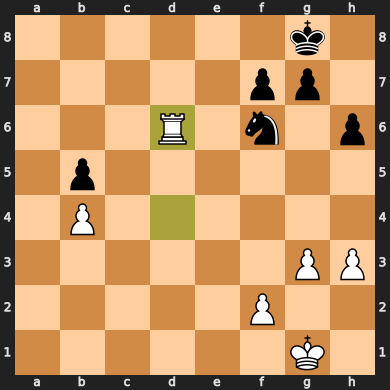

Optimal move suggested and displayed on a virtual chessboard.


In [273]:
# Define initial parameters for the genetic algorithm
initial_fen = fen_string # Use the FEN string detected from the image
generations = 20 # Number of generations to run the GA = EPOCHS
population_size = 100 # Number of individuals in each generation
num_weights = 6 # (pawn_weight, knight_weight, bishop_weight, rook_weight, queen_weight, positional_factor)

# Define bounds for each weight
weight_bounds = [
    (0.5, 1.5), # pawn_weight
    (0.5, 1.5), # knight_weight
    (0.5, 1.5), # bishop_weight
    (0.5, 1.5), # rook_weight
    (0.5, 1.5), # queen_weight
    (0.0, 1.0) # positional_factor
]

mutation_rate = 0.1 # Probability of a weight mutating
mutation_strength = 0.1 # Magnitude of mutation

print("Running genetic algorithm to evolve weights...")
# Run the genetic algorithm to evolve the weights
evolved_weights = run_genetic_algorithm(
    initial_fen,
    generations,
    population_size,
    num_weights,
    weight_bounds,
    mutation_rate,
    mutation_strength
)

print(f"\nEvolved weights: {evolved_weights}")

# Use the evolved weights to suggest the top 5 moves
top_ga_moves = suggest_best_move(initial_fen, evolved_weights, num_moves=5)

if top_ga_moves:
    print(f"\nTop 5 suggested moves from Genetic Algorithm for FEN: {initial_fen}")
    for i, (score, move) in enumerate(top_ga_moves):
        print(f"{i+1}. Move: {move.uci()}, Evaluation Score: {score:.2f}")

    # Plot the very best move (the first one in the sorted list)
    best_move = top_ga_moves[0][1]
    board_with_suggested_move = chess.Board(initial_fen)
    board_with_suggested_move.push(best_move)
    print(f"\nBoard after suggested best move ({best_move.uci()}):")
    display(board_with_suggested_move)
else:
    print("No best move suggested.")

print("Optimal move suggested and displayed on a virtual chessboard.")

## Summary:

### Data Analysis Key Findings
*   A comprehensive `evaluate_board` function was created, incorporating predefined `PIECE_VALUES` for chess pieces and detailed `MAPS` for positional scores (mirrored for black pieces) to assess board states.
*   Core genetic algorithm components (`generate_population`, `select_parents`, `crossover`, `mutate`) were successfully implemented, enabling the creation and evolution of weight sets.
*   The `run_genetic_algorithm` function orchestrated the GA process, running for 20 generations with a population size of 100. It successfully identified and tracked the best set of weights, with fitness determined by the maximum `evaluate_board` score of possible next moves.
*   The `suggest_best_move` function was implemented to leverage the evolved weights for optimal move determination, by evaluating all legal moves and selecting the one that yields the best score according to the evolved evaluation function.
*   Initial debugging involved correcting an `AttributeError` in `evaluate_board` from `board.pieceat` to `board.piece_at`.
*   A critical logical error in `suggest_best_move` was identified and fixed: the `board.turn` was being checked *after* making a temporary move, which incorrectly switched the player. The fix involved storing the `original_turn` before the move evaluation loop to ensure correct score maximization/minimization.
*   Following these corrections, the full pipeline successfully executed, displaying an optimal move (e.g., `f3e5`) for the given FEN and visualizing the board after the suggested move.


## Combine recommender system and genetic algorithm to select final recommendation



Only GA recommendations available. Using GA's top move: d4d6

Final Recommended Move: d4d6
Board after final recommended move:


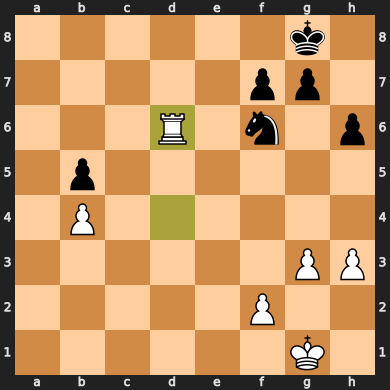

In [274]:
final_recommended_move = None

# Extract UCI strings from top_ga_moves (list of (score, chess.Move) tuples)
ga_moves_uci_list = [move.uci() for score, move in top_ga_moves]

# Extract UCI strings from recommended_moves_start (DataFrame)
lichess_moves_uci_list = recommended_moves_start['move'].tolist()

# Case 1: Both GA and Lichess lists are empty
if not ga_moves_uci_list and not lichess_moves_uci_list:
    print("Neither GA nor Lichess API provided a move recommendation.")

# Case 2: Only GA list is available
elif ga_moves_uci_list and not lichess_moves_uci_list:
    final_recommended_move = top_ga_moves[0][1] # Get the chess.Move object
    print(f"Only GA recommendations available. Using GA's top move: {final_recommended_move.uci()}")

# Case 3: Only Lichess list is available
elif not ga_moves_uci_list and lichess_moves_uci_list:
    final_recommended_move = chess.Move.from_uci(lichess_moves_uci_list[0])
    print(f"Only Lichess recommendations available. Using Lichess's top move: {final_recommended_move.uci()}")

# Case 4: Both GA and Lichess lists are available
else:
    common_moves_uci = list(set(ga_moves_uci_list).intersection(set(lichess_moves_uci_list)))

    if common_moves_uci: # If there is any overlap
        # Prioritize GA's top common move
        found_common_ga_move = False
        for score, move in top_ga_moves:
            if move.uci() in common_moves_uci:
                final_recommended_move = move
                print(f"Overlap found. Using GA's highest-ranked common move: {final_recommended_move.uci()}")
                found_common_ga_move = True
                break
        if not found_common_ga_move and common_moves_uci:
            final_recommended_move = chess.Move.from_uci(common_moves_uci[0])
            print(f"Overlap found but GA's top common move not identified cleanly. Using first common move: {final_recommended_move.uci()}")
    else:
        final_recommended_move = top_ga_moves[0][1]
        print(f"No overlap between top GA and Lichess moves. Choosing GA's top move: {final_recommended_move.uci()}")

# Display the final recommended move if found
if final_recommended_move:
    print(f"\nFinal Recommended Move: {final_recommended_move.uci()}")
    board_after_final_recommendation = chess.Board(initial_fen)
    board_after_final_recommendation.push(final_recommended_move)
    print("Board after final recommended move:")
    display(board_after_final_recommendation)
else:
    print("No final move could be recommended.")

In [275]:
# Refactored combining logic into a function
def combine_and_select_best_move(board: chess.Board, evolved_weights, move_stats):
    current_fen = board.fen()

    # Store all forbidden moves in a set for efficient lookup
    forbidden_moves_uci = set()

    # 1. Prevent immediate reversal of opponent's last move
    if board.move_stack: # Check if there are any moves on the board
        last_opponent_move = board.peek() # This is the opponent's (user's/Stockfish's) last move
        forbidden_moves_uci.add(chess.Move(last_opponent_move.to_square, last_opponent_move.from_square).uci())

    # 2. Prevent a piece from immediately returning to the square it just left (model's previous move)
    # This applies if the board has enough history to determine the model's last move
    # Example: Model moved Ra1-a2, Opponent moved X, Model should not move Ra2-a1
    if len(board.move_stack) >= 2: # At least model's move + opponent's move
        # The move *before* the last_opponent_move was the model's previous move
        model_previous_move = board.move_stack[-2] # Get the move before the current top of stack
        # If the model's previous move moved a piece from X to Y, then moving that piece from Y to X should be forbidden
        forbidden_moves_uci.add(chess.Move(model_previous_move.to_square, model_previous_move.from_square).uci())

    top_ga_moves = suggest_best_move(current_fen, evolved_weights, num_moves=10)
    recommended_lichess_moves = recommend_moves_with_entropy(current_fen, move_stats, n=10)

    final_recommended_move = None

    # Filter out forbidden moves from GA recommendations
    filtered_ga_moves = []
    for score, move in top_ga_moves:
        if move.uci() not in forbidden_moves_uci:
            filtered_ga_moves.append((score, move))

    # Filter out forbidden moves from Lichess recommendations
    filtered_lichess_moves_df = recommended_lichess_moves[~recommended_lichess_moves['move'].isin(forbidden_moves_uci)]
    filtered_lichess_moves_uci_list = filtered_lichess_moves_df['move'].tolist()

    ga_moves_uci_list = [move.uci() for score, move in filtered_ga_moves]
    lichess_moves_uci_list = filtered_lichess_moves_uci_list

    # Case 1: Both GA and Lichess lists are empty (after filtering)
    if not ga_moves_uci_list and not lichess_moves_uci_list:
        # If no recommendations after filtering, return None to let the calling code handle a fallback
        return None

    # Case 2: Only GA list is available (after filtering)
    elif ga_moves_uci_list and not lichess_moves_uci_list:
        if filtered_ga_moves:
            final_recommended_move = filtered_ga_moves[0][1] # Get the chess.Move object

    # Case 3: Only Lichess list is available (after filtering)
    elif not ga_moves_uci_list and lichess_moves_uci_list:
        if filtered_lichess_moves_uci_list:
            final_recommended_move = chess.Move.from_uci(filtered_lichess_moves_uci_list[0])

    # Case 4: Both GA and Lichess lists are available (after filtering)
    else:
        common_moves_uci = list(set(ga_moves_uci_list).intersection(set(lichess_moves_uci_list)))

        if common_moves_uci: # If there is any overlap
            # Prioritize Lichess's highest-ranked common move
            found_common_lichess_move = False
            for index, row in filtered_lichess_moves_df.iterrows(): # Use filtered_lichess_moves_df
                move_uci = row['move']
                if move_uci in common_moves_uci:
                    final_recommended_move = chess.Move.from_uci(move_uci)
                    found_common_lichess_move = True
                    break
            if not found_common_lichess_move and common_moves_uci: # Fallback just in case
                final_recommended_move = chess.Move.from_uci(common_moves_uci[0])
        else:
            # If no common moves, default to GA's top move
            if filtered_ga_moves:
                final_recommended_move = filtered_ga_moves[0][1]

    return final_recommended_move

## Letting the algorithm play against Stockfish

In [276]:

def stockfish_init():
    STOCKFISH_URL = (
        "https://github.com/official-stockfish/Stockfish/releases/latest/download/stockfish-ubuntu-x86-64-avx2.tar"
    )
    STOCKFISH_FILENAME = "stockfish-ubuntu-x86-64-avx2.tar"
    STOCKFISH_PATH = "/content/stockfish/stockfish-ubuntu-x86-64-avx2"

    # --- DOWNLOAD ---
    print("Downloading Stockfish...")
    subprocess.run(
        ["wget", "-L", "-O", STOCKFISH_FILENAME, STOCKFISH_URL],
        check=True
    )

    # --- EXTRACT ---
    print("Extracting...")
    subprocess.run(["tar", "-xvf", STOCKFISH_FILENAME], check=True)

    # --- MAKE EXECUTABLE ---
    print("Setting executable permissions...")
    subprocess.run(["chmod", "+x", STOCKFISH_PATH], check=True)

    print("Stockfish ready!")
    return STOCKFISH_PATH

In [277]:
STOCKFISH_PATH = stockfish_init()

Extracting...
Setting executable permissions...
Stockfish ready!


Chess Game with Recommendation system only (Stockfish as fallback)

Stockfish plays white and begins!
Model plays: d4d6


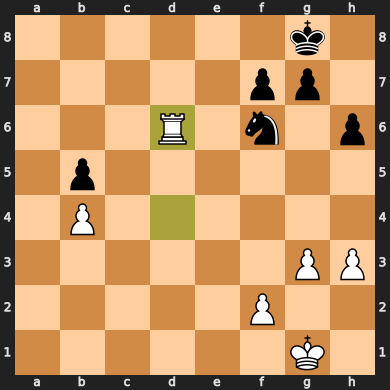

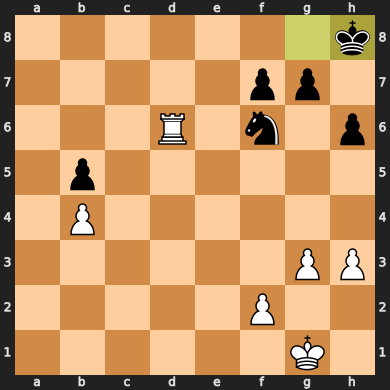

Stockfish plays: g8h8
Model plays: d6d8


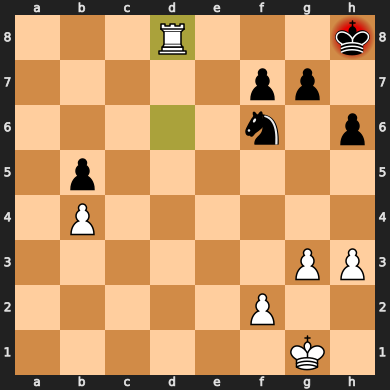

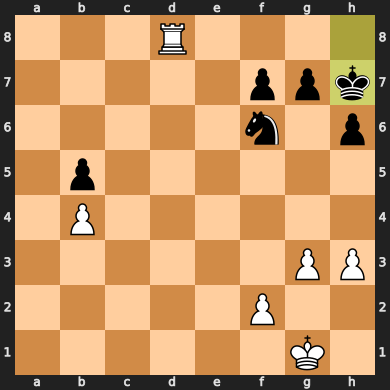

Stockfish plays: h8h7
Model plays: g1g2


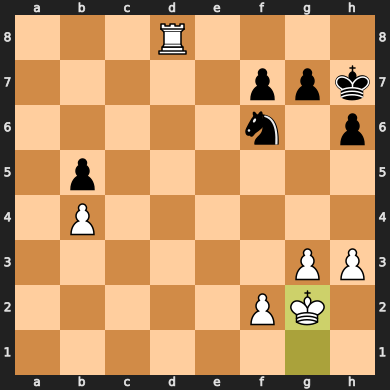

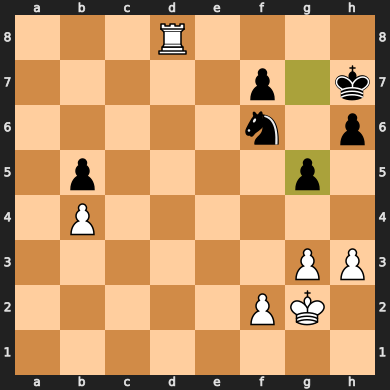

Stockfish plays: g7g5
Model plays: d8d4


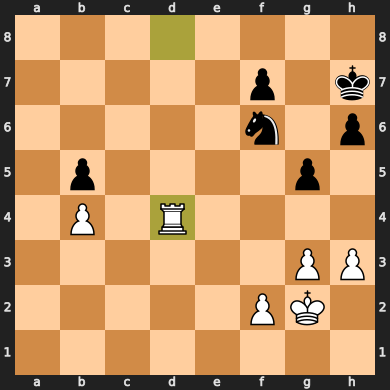

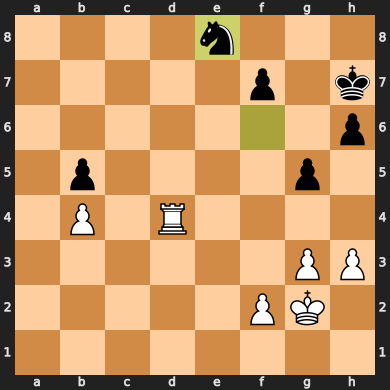

Stockfish plays: f6e8
Model plays: d4d5


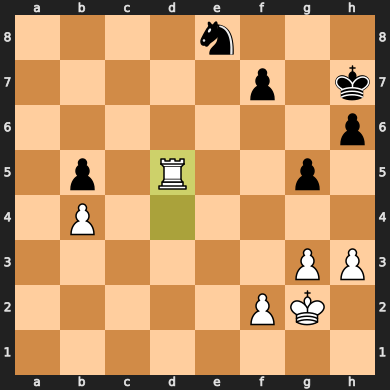

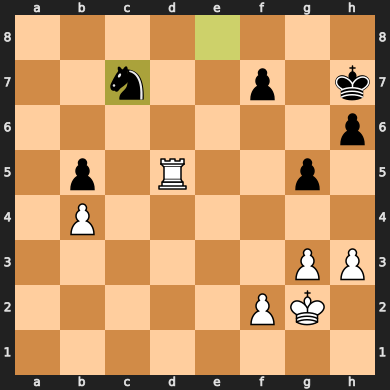

Stockfish plays: e8c7
Model plays: d5c5


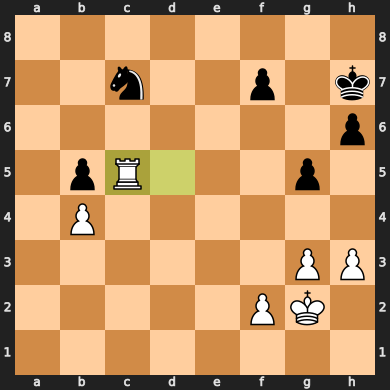

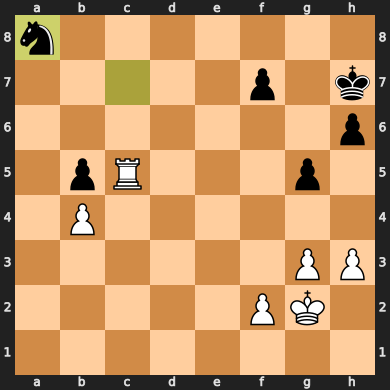

Stockfish plays: c7a8
Model plays: g2h2


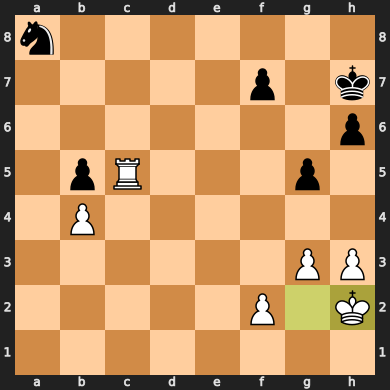

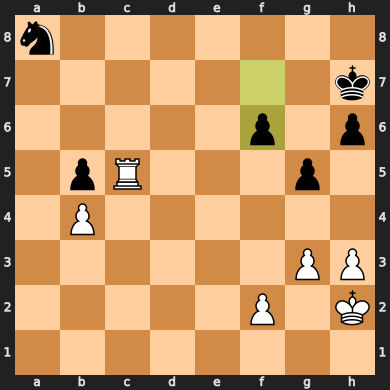

Stockfish plays: f7f6
Model plays: h2g1


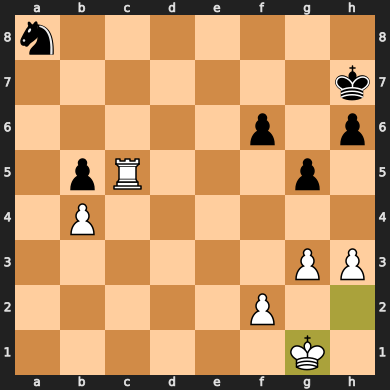

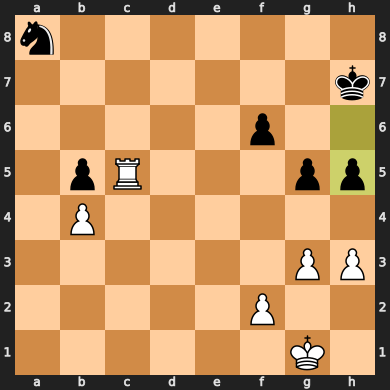

Stockfish plays: h6h5
Model plays: c5b5


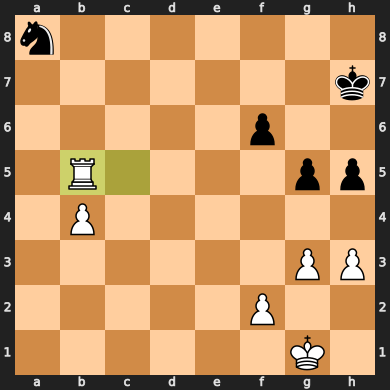

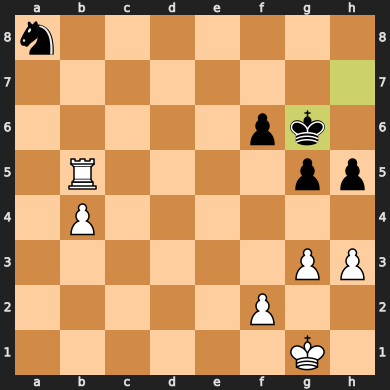

Stockfish plays: h7g6
Model plays: b5c5


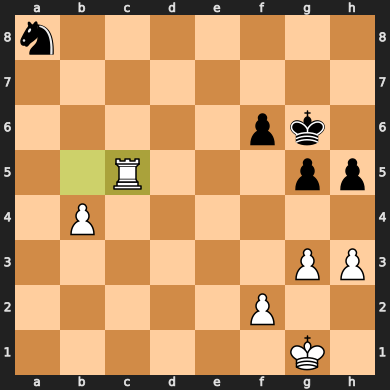

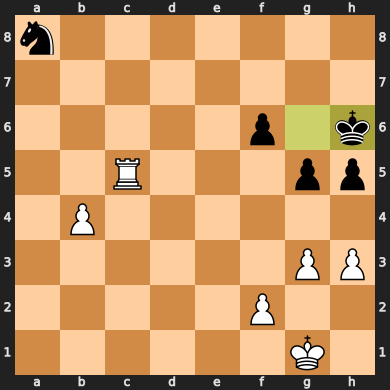

Stockfish plays: g6h6
Model plays: b4b5


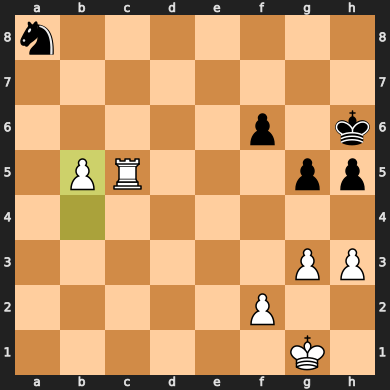

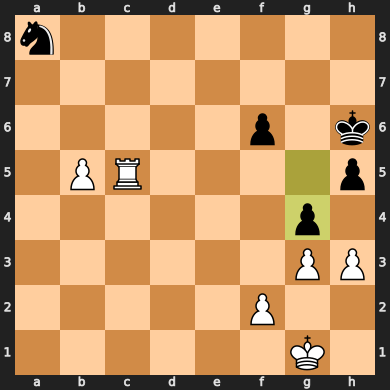

Stockfish plays: g5g4
Model plays: c5c8


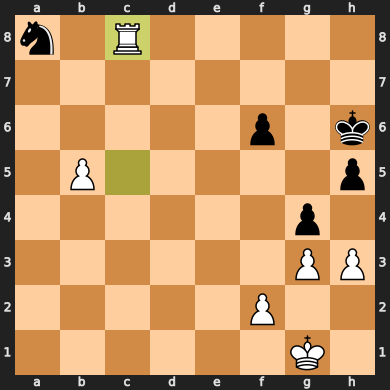

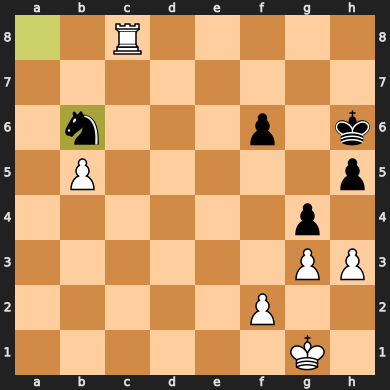

Stockfish plays: a8b6
Model plays: c8c5


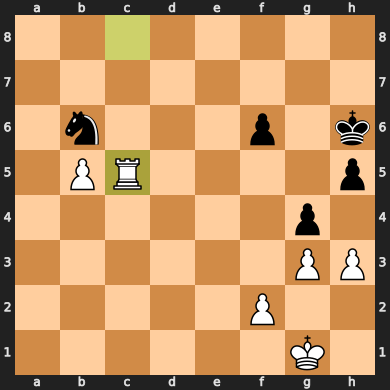

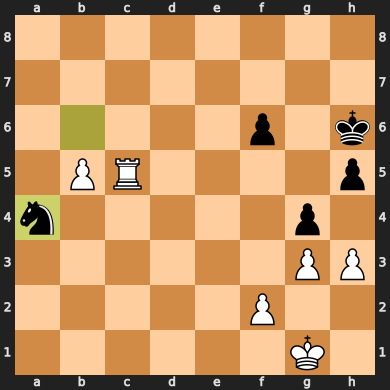

Stockfish plays: b6a4
Model plays: c5c7


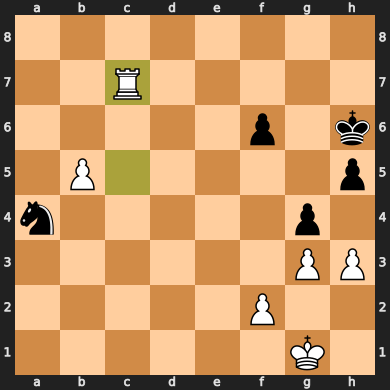

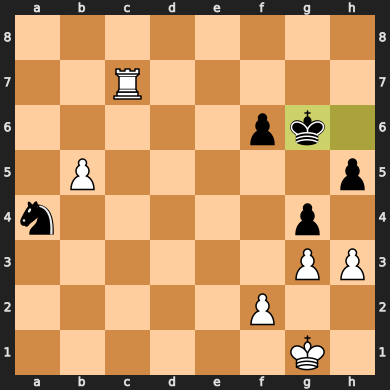

Stockfish plays: h6g6
Model plays: c7c6


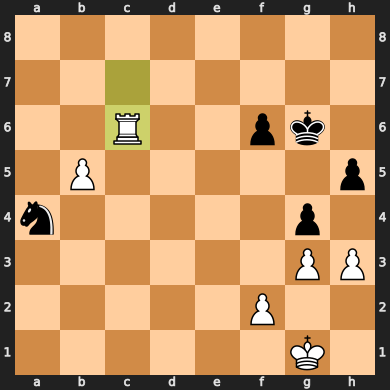

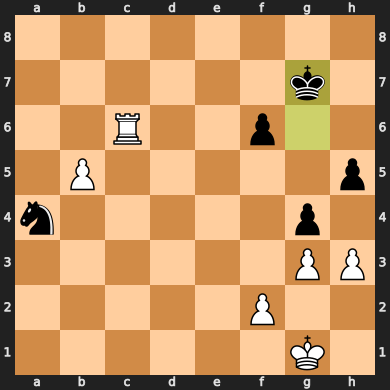

Stockfish plays: g6g7
Model plays: h3g4


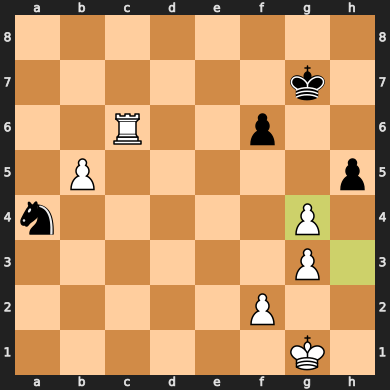

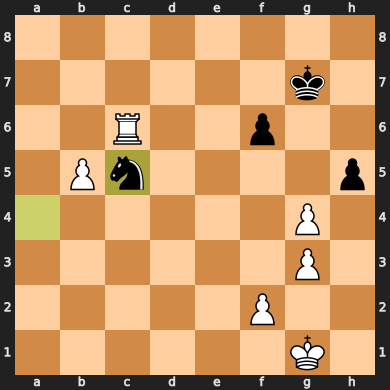

Stockfish plays: a4c5
Model plays: b5b6


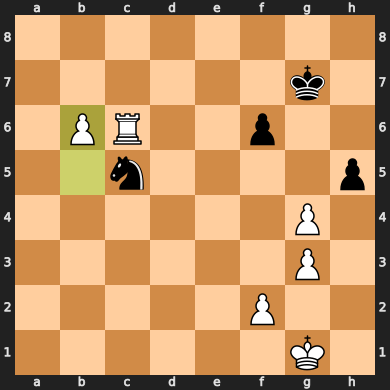

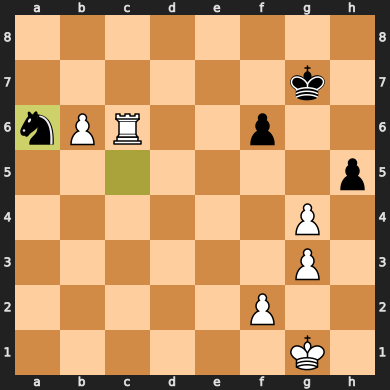

Stockfish plays: c5a6
Model plays: b6b7


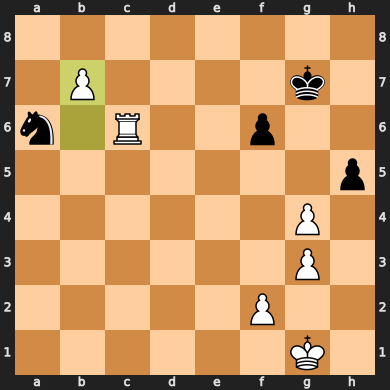

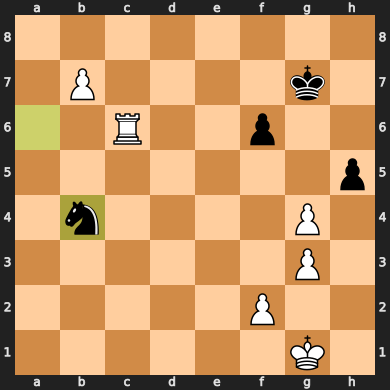

Stockfish plays: a6b4
Model plays: c6c7


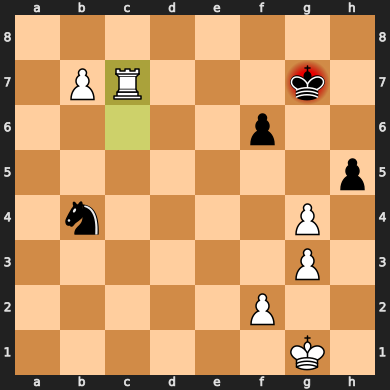

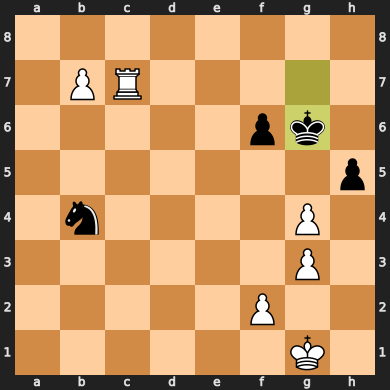

Stockfish plays: g7g6
Model plays: c7c4


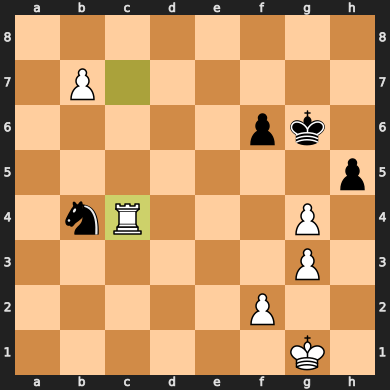

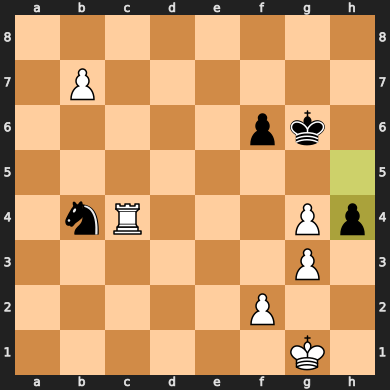

Stockfish plays: h5h4
Model plays: g3h4


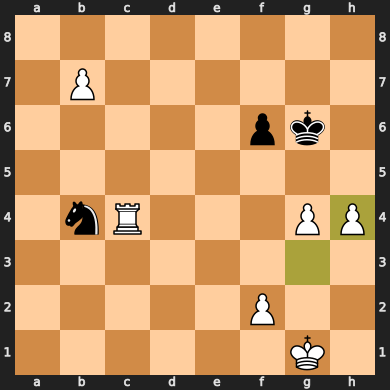

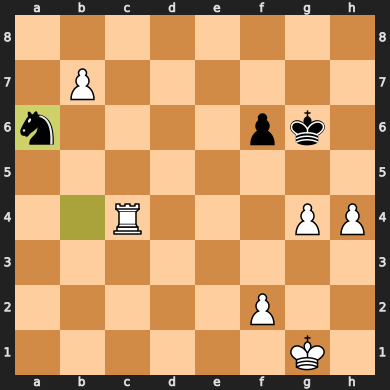

Stockfish plays: b4a6
Model plays: c4d4


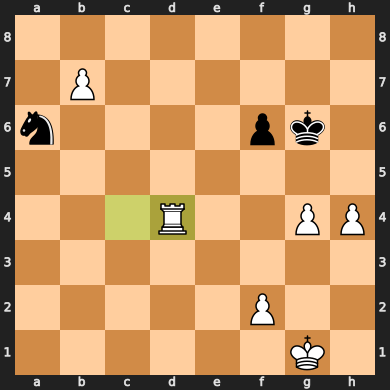

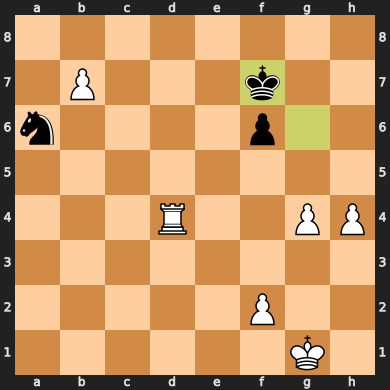

Stockfish plays: g6f7
Model plays: d4d1


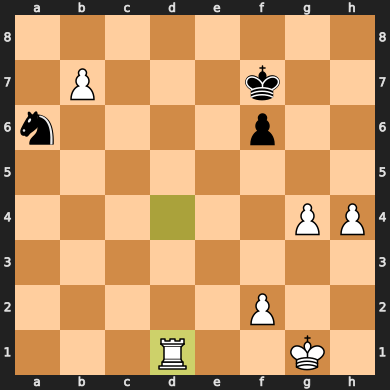

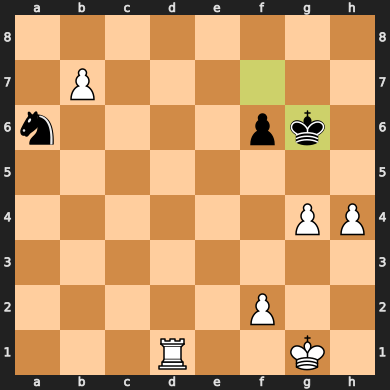

Stockfish plays: f7g6
Model plays: d1c1


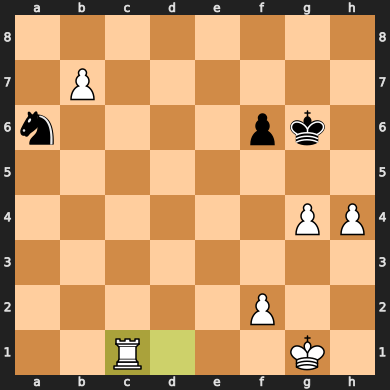

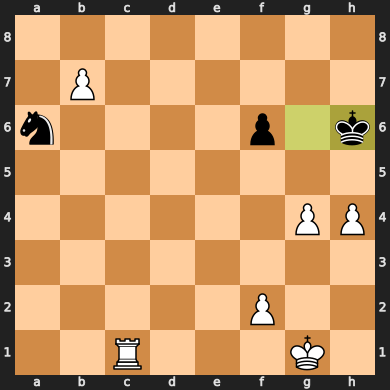

Stockfish plays: g6h6
Model plays: c1c8


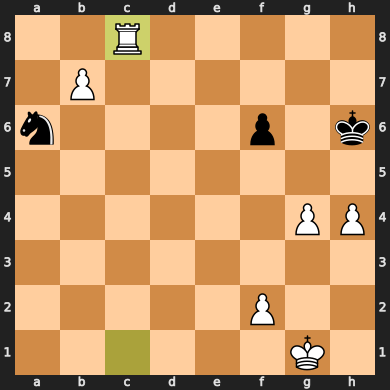

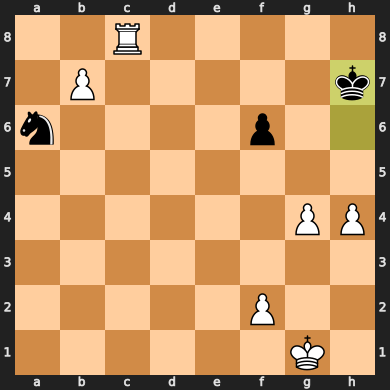

Stockfish plays: h6h7
Model plays: g1h2


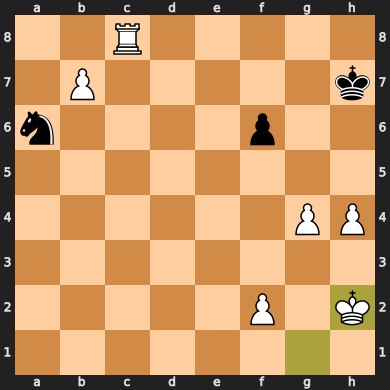

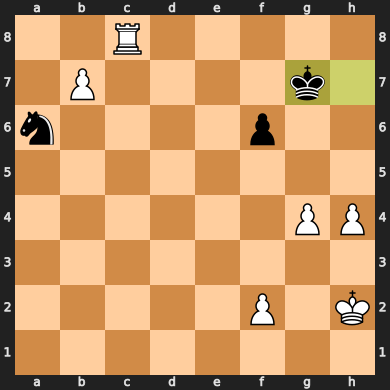

Stockfish plays: h7g7
Model plays: h2g2


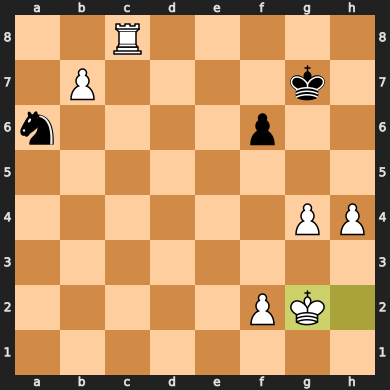

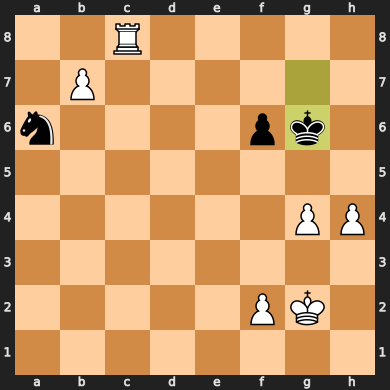

Stockfish plays: g7g6
Model plays: c8h8


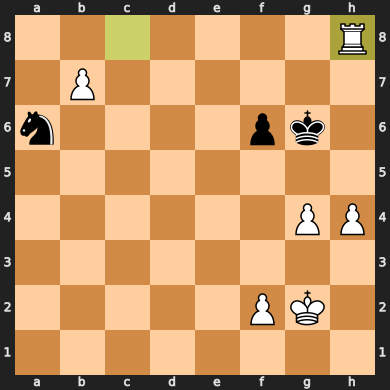

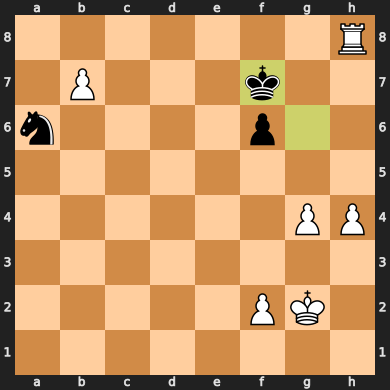

Stockfish plays: g6f7
Model plays: h8a8


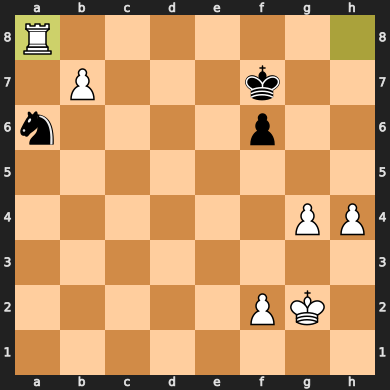

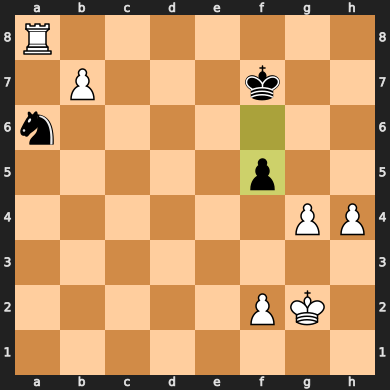

Stockfish plays: f6f5
Model plays: a8a6


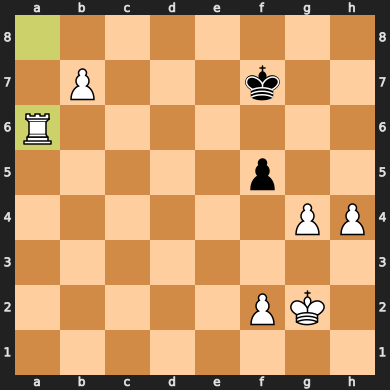

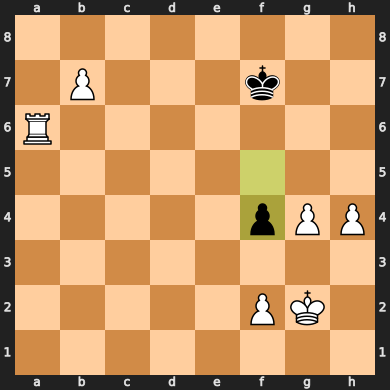

Stockfish plays: f5f4
Model plays: b7b8q


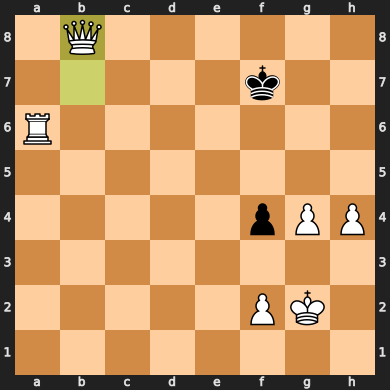

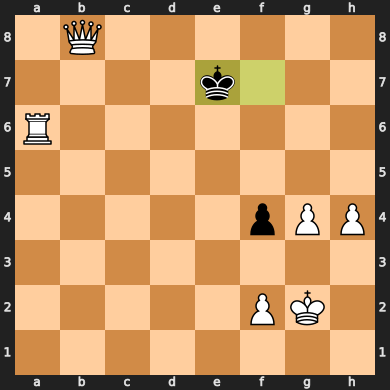

Stockfish plays: f7e7
Model plays: g2h2


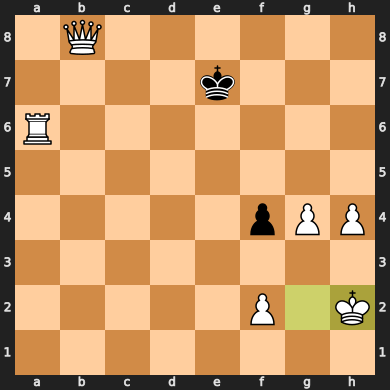

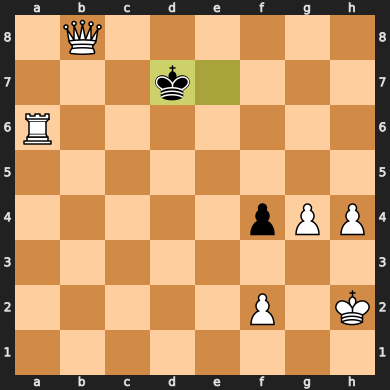

Stockfish plays: e7d7
Model plays: b8b7


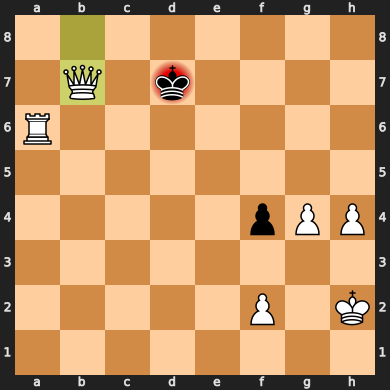

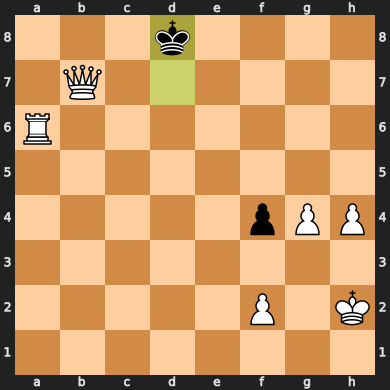

Stockfish plays: d7d8
Model plays: g4g5


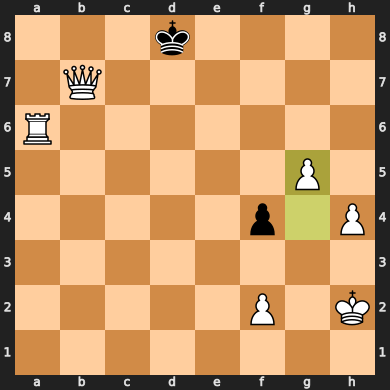

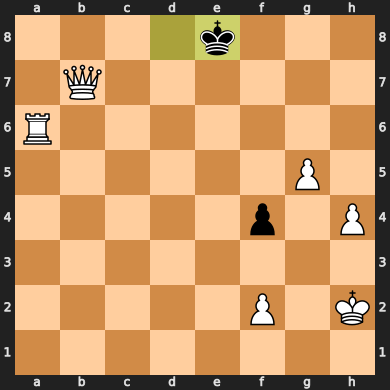

Stockfish plays: d8e8
Model plays: f2f3


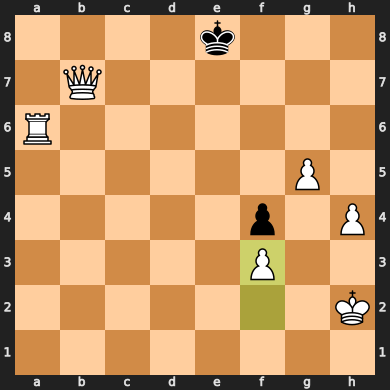

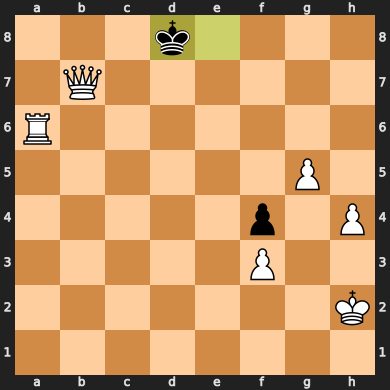

Stockfish plays: e8d8
Model plays: a6a8


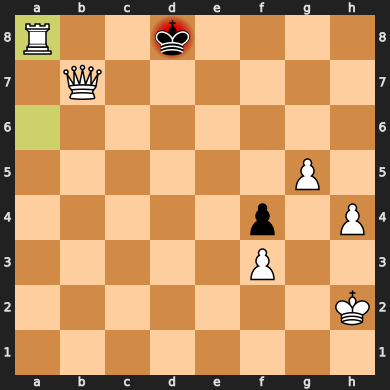


Game over! Result: 1-0
Stockfish (white) wins!


In [278]:
# Start engine with an elo of 2300
engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)
engine.configure({
    "UCI_LimitStrength": True,
    "UCI_Elo": 2300
})

board = chess.Board(fen_string)

# Randomly decide who plays white
if random.random() < 0.5:
    model_color = chess.WHITE
    engine_color = chess.BLACK
    print("Model plays white and begins!")
else:
    model_color = chess.BLACK
    engine_color = chess.WHITE
    print("Stockfish plays white and begins!")

while not board.is_game_over():

    # === Selfmade MODEL ===
    df_move = recommend_moves_with_entropy(board.fen(), move_stats, n=1)

    # --- SAFE MOVE SELECTION ---
    if df_move is None or df_move.empty or "move" not in df_move.columns:
        # Fallback: Stockfish speelt
        move_to_play = engine.play(
            board, chess.engine.Limit(depth=12)
        ).move.uci()
        #print("Fallback to Stockfish:", move_to_play)
    else:
        move_to_play = df_move.iloc[0]["move"]

    # alter to chess.Move
    my_move = chess.Move.from_uci(move_to_play)

    # Final safety check
    if my_move not in board.legal_moves:
        # fallback
        my_move = list(board.legal_moves)[0]
        move_to_play = my_move.uci()
        print("Illegal move replaced with:", move_to_play)

    board.push(my_move)
    print("Model plays:", move_to_play)
    display(board)

    if board.is_game_over():
        break

    # === STOCKFISH TEGENZET ===
    reply = engine.play(board, chess.engine.Limit(depth=12))
    board.push(reply.move)
    display(board)
    print("Stockfish plays:", reply.move.uci())

# ===== GAME OVER =====
result = board.result()  # "1-0", "0-1", "1/2-1/2"
print("\nGame over! Result:", result)

# Decide which model won based on the model_color
if result == "1/2-1/2":
    print("Remise!")
else:
    # Determine of white or black
    white_won = (result == "1-0")
    black_won = (result == "0-1")

    # Match to the created model or to stockfish
    if (white_won and model_color == chess.WHITE) or (black_won and model_color == chess.BLACK):
        # Selfmade model has won the game
        color = "white" if model_color == chess.WHITE else "black"
        print(f"Model ({color}) wins!")
    else:
        # Stockfish won the game
        color = "white" if (model_color == chess.BLACK) else "black"
        print(f"Stockfish ({color}) wins!")

engine.quit()

recommender + genetic

Model plays white and begins!
Model plays: d4d6


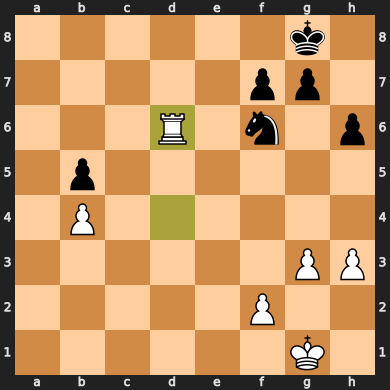

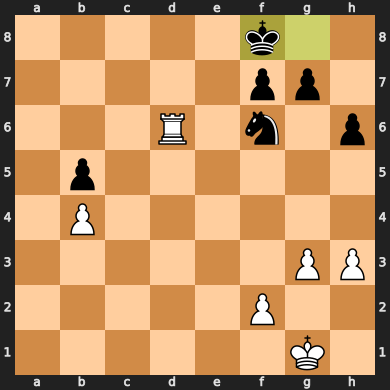

Stockfish plays: g8f8
Model plays: d6f6


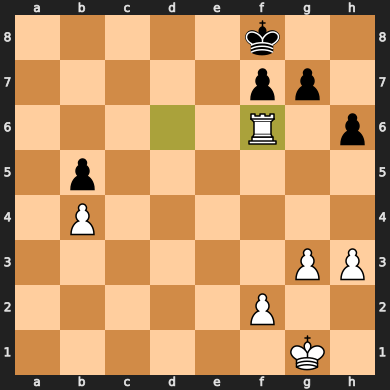

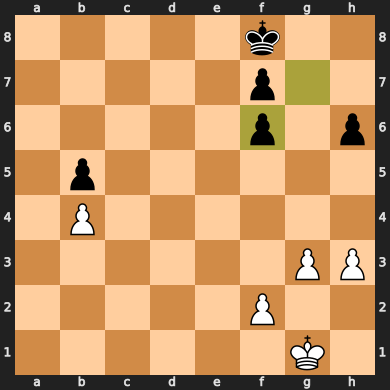

Stockfish plays: g7f6
Model plays: g1h2


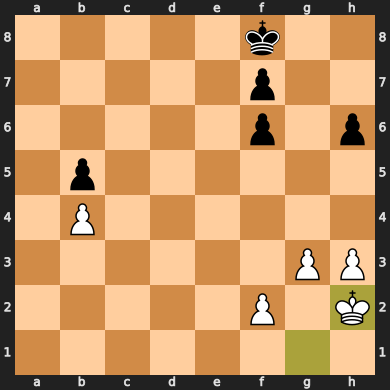

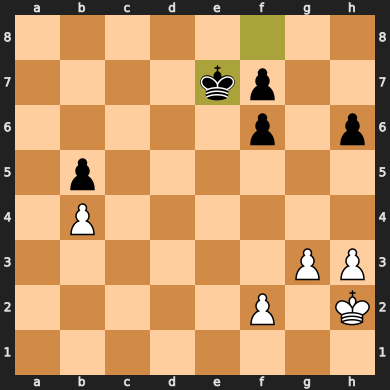

Stockfish plays: f8e7
Model plays: h2g2


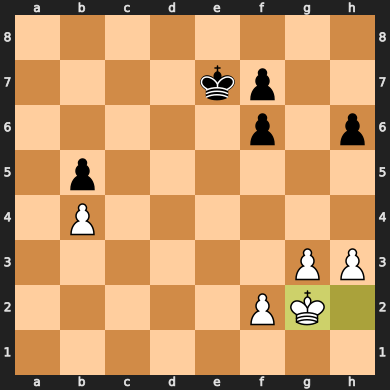

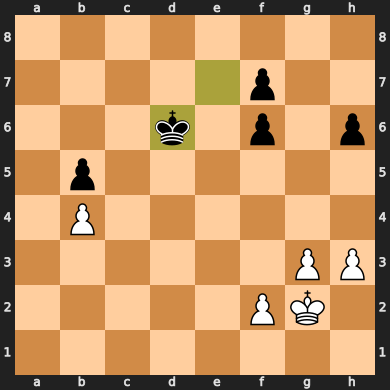

Stockfish plays: e7d6
Model plays: g2f3


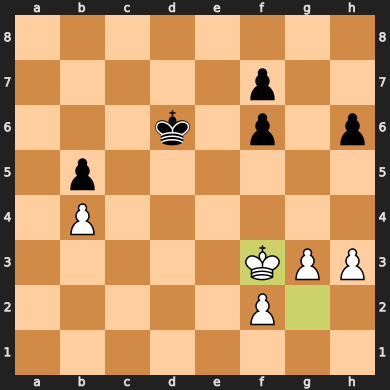

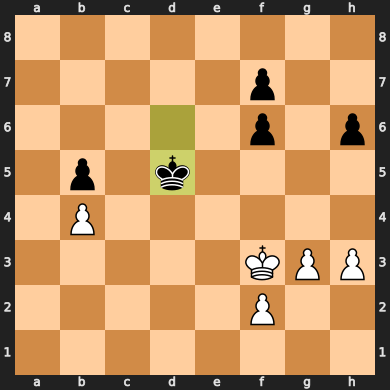

Stockfish plays: d6d5
Model plays: f3g4


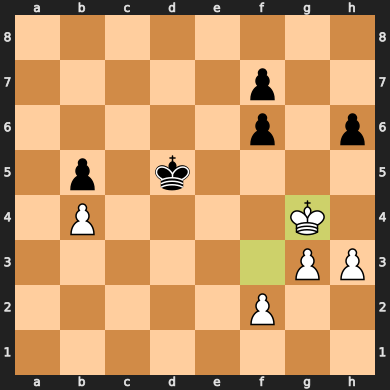

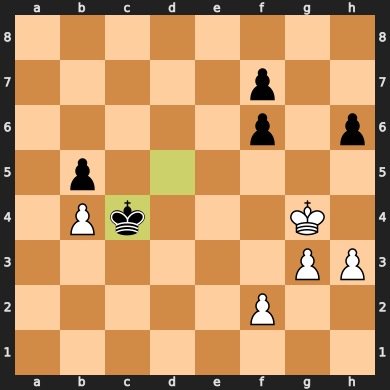

Stockfish plays: d5c4
Model plays: g4h5


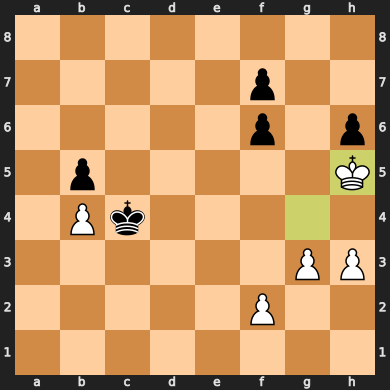

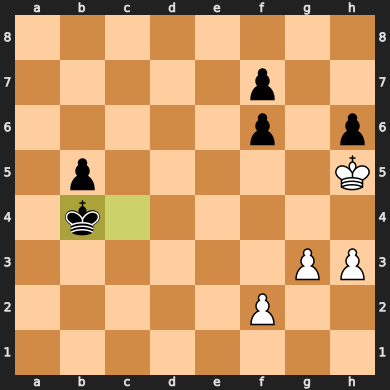

Stockfish plays: c4b4
Model plays: h5h6


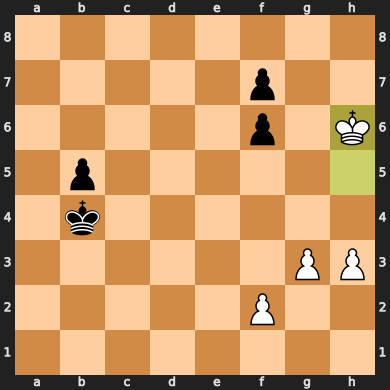

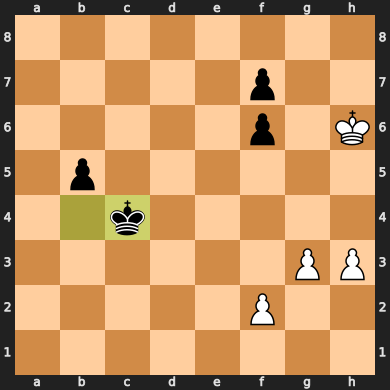

Stockfish plays: b4c4
Model plays: h6h7


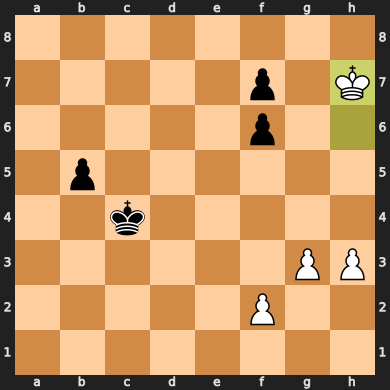

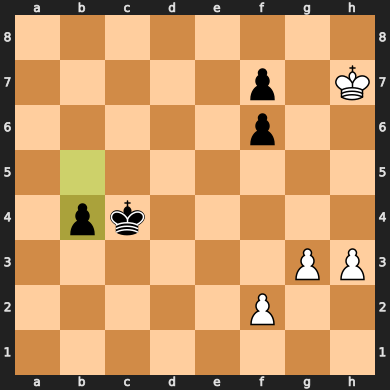

Stockfish plays: b5b4
Model plays: h7h8


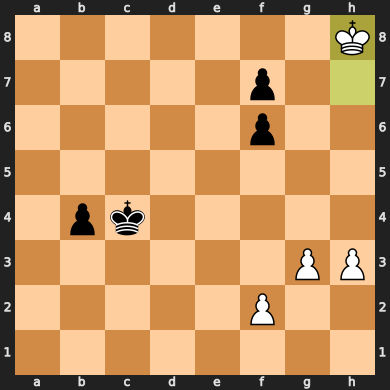

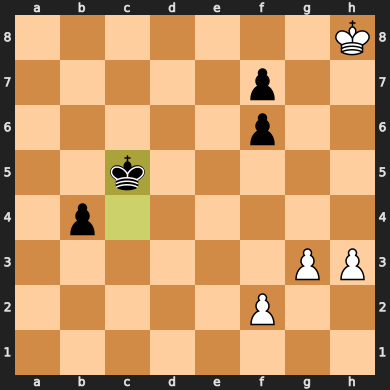

Stockfish plays: c4c5
Model plays: h8g8


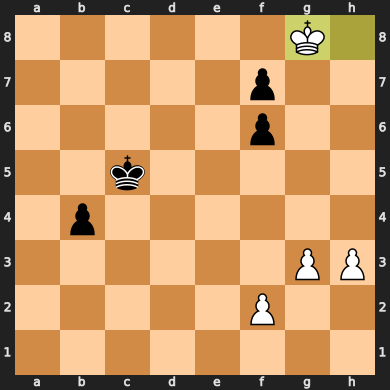

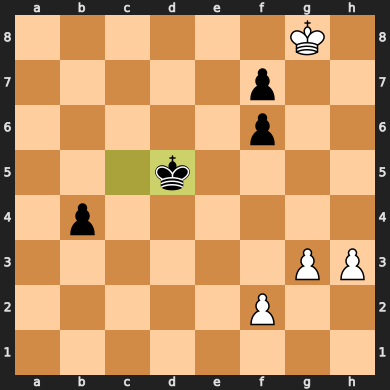

Stockfish plays: c5d5
Model plays: g8f7


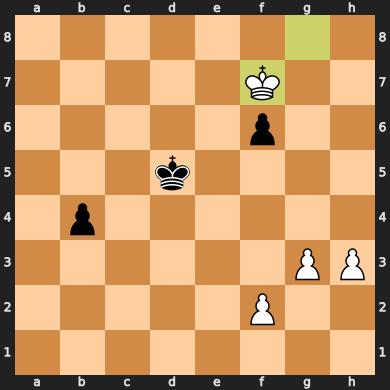

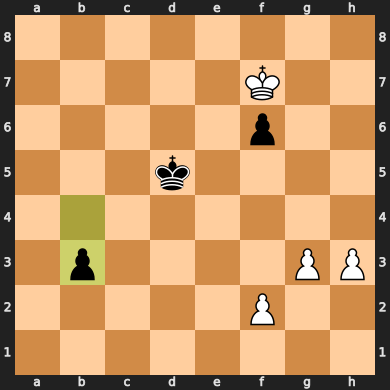

Stockfish plays: b4b3
Model plays: f7f6


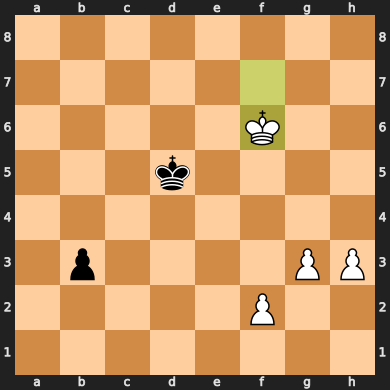

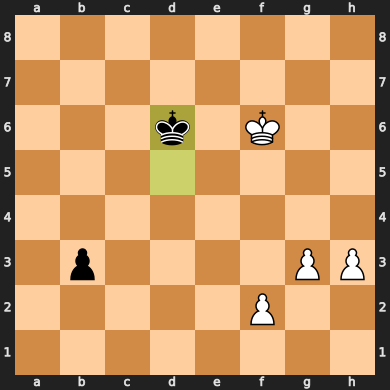

Stockfish plays: d5d6
Model plays: f6g7


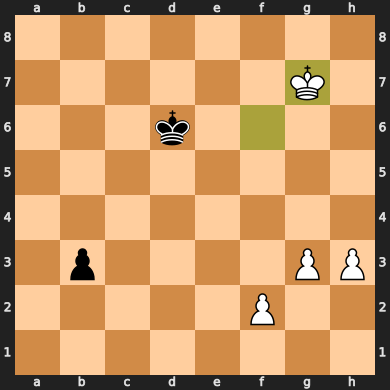

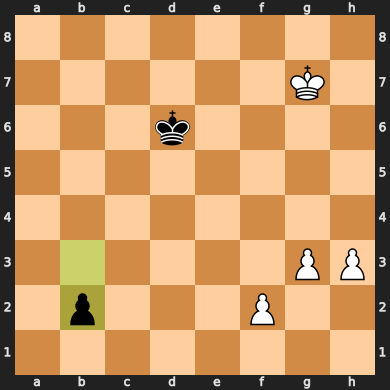

Stockfish plays: b3b2
Model plays: g7h8


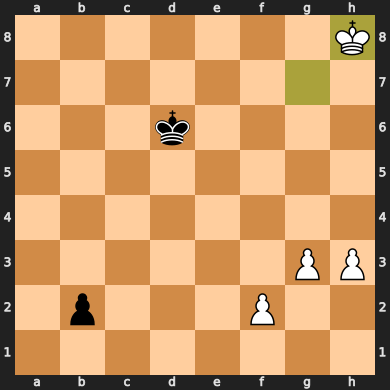

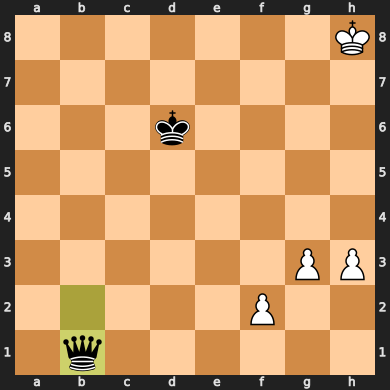

Stockfish plays: b2b1q
Model plays: h8g8


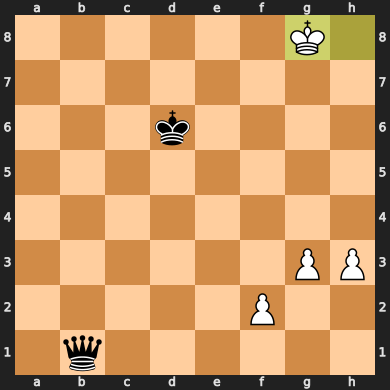

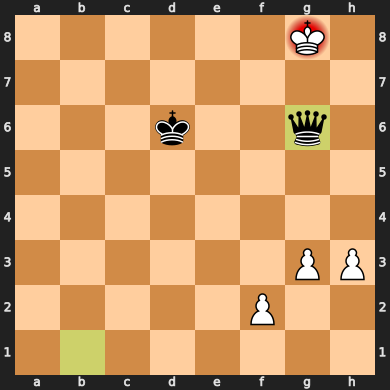

Stockfish plays: b1g6
Model plays: g8f8


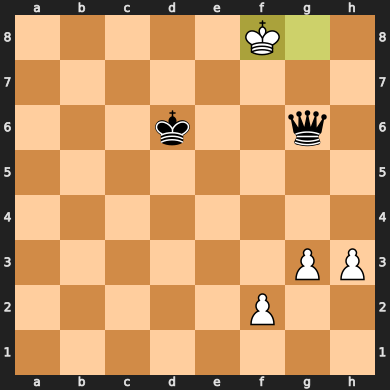

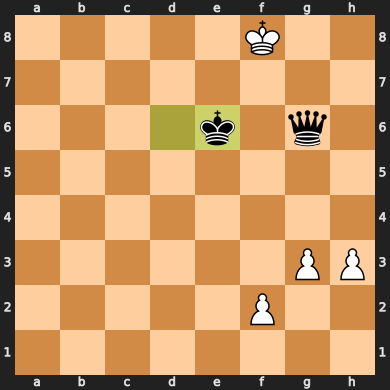

Stockfish plays: d6e6
Model plays: h3h4


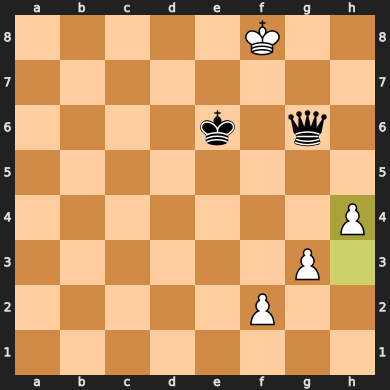

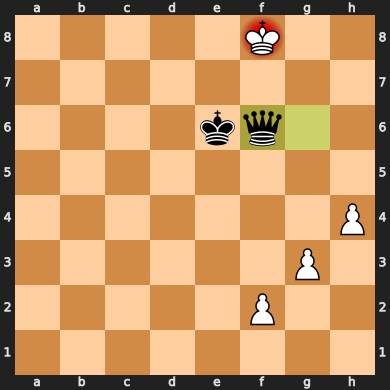

Stockfish plays: g6f6
Model plays: f8g8


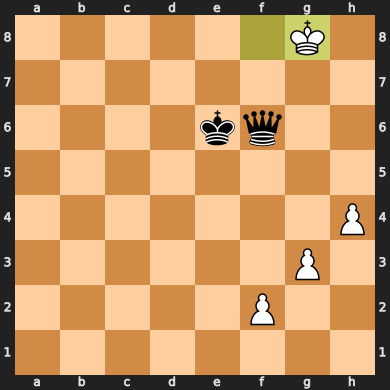

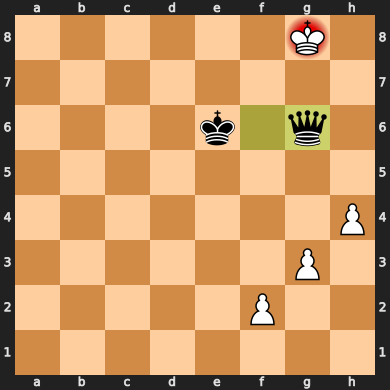

Stockfish plays: f6g6
Model plays: g8h8


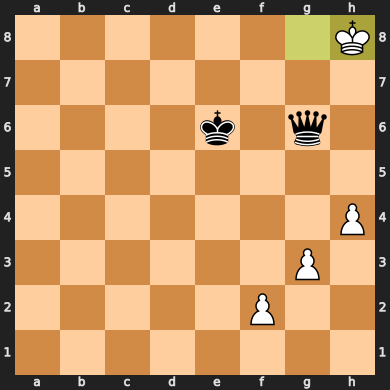

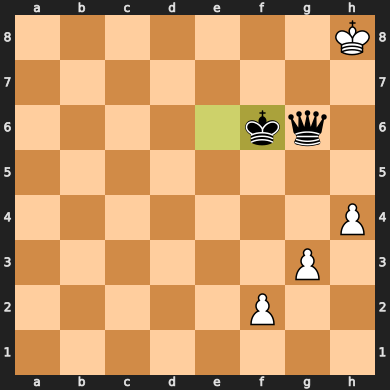

Stockfish plays: e6f6
Model plays: h4h5


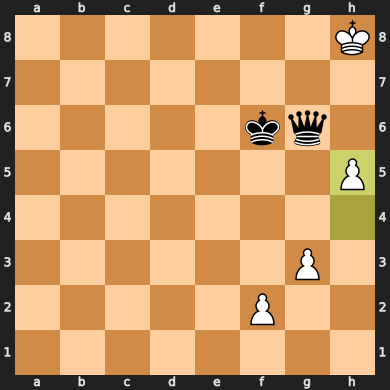

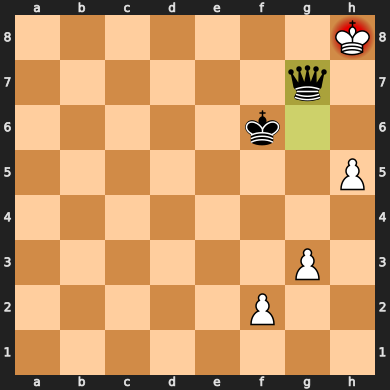

Stockfish plays: g6g7

Game over! Result: 0-1
Stockfish (black) wins!


In [280]:
# By default, it uses the FEN generated from the image, but you can override it.
start_game_fen = fen_string

# Start engine
engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)
engine.configure(
    {
        "UCI_LimitStrength": True,
        "UCI_Elo": 2300
    }
)

board = chess.Board(fen_string)

# Randomly decide who plays white
if random.random() < 0.5:
    model_color = chess.WHITE
    engine_color = chess.BLACK
    print("Model plays white and begins!")
else:
    model_color = chess.BLACK
    engine_color = chess.WHITE
    print("Stockfish plays white and begins!")

while not board.is_game_over():

    # === Selfmade MODEL ===
    # Get the combined recommendation
    my_move_obj = combine_and_select_best_move(board, evolved_weights, move_stats)

    my_move = None
    move_to_play_uci = None

    if my_move_obj and my_move_obj in board.legal_moves:
        my_move = my_move_obj
        move_to_play_uci = my_move.uci()
    else:
        print("Combined recommendation failed or is illegal. Falling back to safe legal move.")
        legal_moves = list(board.legal_moves)
        if legal_moves:
            # Attempt to find a fallback move that is not an immediate reverse of Stockfish's last move
            fallback_move = None
            forbidden_reverse_uci_in_fallback = None
            # Stockfish's last move would be the last one pushed by the engine before the current model's turn
            if board.move_stack:
                last_stockfish_move = board.peek()
                forbidden_reverse_uci_in_fallback = chess.Move(last_stockfish_move.to_square, last_stockfish_move.from_square).uci()

            for move in legal_moves:
                if move.uci() != forbidden_reverse_uci_in_fallback:
                    fallback_move = move
                    break

            if fallback_move:
                my_move = fallback_move
                move_to_play_uci = my_move.uci()
            else:
                # If all legal moves are forbidden reverse, or no non-reverse moves found, just pick the first legal move
                my_move = legal_moves[0]
                move_to_play_uci = my_move.uci()
                print("Warning: All legal moves are forbidden reverse, picking first legal move.")
        else:
            print("Model has no legal moves. Game over?")
            break # No legal moves, so game might be over or stalemate/checkmate

    board.push(my_move)
    print("Model plays:", move_to_play_uci)
    display(board)

    if board.is_game_over():
        break

    # === STOCKFISH TEGENZET ===
    reply = engine.play(board, chess.engine.Limit(depth=12))
    board.push(reply.move)
    display(board)
    print("Stockfish plays:", reply.move.uci())

# ===== GAME OVER =====
result = board.result()  # "1-0", "0-1", "1/2-1/2"
print("\nGame over! Result:", result)

# Decide which model won based on the model_color
if result == "1/2-1/2":
    print("Remise!")
else:
    # Determine of white or black
    white_won = (result == "1-0")
    black_won = (result == "0-1")

    # Match to the created model or to stockfish
    if (white_won and model_color == chess.WHITE) or (black_won and model_color == chess.BLACK):
        # Selfmade model has won the game
        color = "white" if model_color == chess.WHITE else "black"
        print(f"Model ({color}) wins!")
    else:
        # Stockfish won the game
        color = "white" if (model_color == chess.BLACK) else "black"
        print(f"Stockfish ({color}) wins!")